## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
data_df = data_df.fillna('')
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.220007     590.851292   -30.129462     -35.559056   
1            2     -1.220007     590.851292   -30.129462     -35.559056   
2            3     -1.220007     590.851292   -30.129462     -35.559056   
3            4     -1.220007     590.851292   -30.129462     -35.559056   
4            5     -1.220007     590.851292   -30.129462     -35.559056   
...        ...           ...            ...          ...            ...   
3065970     21      3.860010     597.535984    25.682372      36.658380   
3065971     22      3.860010     597.535984    25.682372      36.658380   
3065972     23      3.860010     597.535984    25.682372      36.658380   
3065973     24      3.860010     597.535984    25.682372      36.658380   
3065974     25      3.860010     597.535984    25.682372      36.658380   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 122639
Number of training points: 1839575


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix03']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1839575, 26)
(1226400, 26)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [20]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [21]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

print(train_std[m0_output_column_ix[0]])
print(train_mean[m0_output_column_ix[0]])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14
6.534936750508448
7.0633593974716415


In [22]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [23]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [24]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.00029189952
RMSE of after m1 0.8203211
RMSE of after m2 0.42201194
RMSE of after m3 0.17701489
RMSE of after m4 0.17674342
RMSE of after m0 0.0002657973
RMSE of after m1 0.7427424
RMSE of after m2 0.69531924
RMSE of after m3 0.1821392
RMSE of after m4 0.18210119
RMSE of after m0 0.0002682778
RMSE of after m1 0.73037225
RMSE of after m2 0.19040965
RMSE of after m3 0.09940744
RMSE of after m4 0.09965393
RMSE of after m0 0.00026245267
RMSE of after m1 0.7214254
RMSE of after m2 0.5366472
RMSE of after m3 0.09996168
RMSE of after m4 0.10006954
RMSE of after m0 0.00025182773
RMSE of after m1 0.6361745
RMSE of after m2 0.4576226
RMSE of after m3 0.08201759
RMSE of after m4 0.08199401
RMSE of after m0 0.00023454186
RMSE of after m1 0.57111347
RMSE of after m2 0.47717556
RMSE of after m3 0.08284427
RMSE of after m4 0.08277907
RMSE of after m0 0.00024618732
RMSE of after m1 0.50591993
RMSE of after m2 0.41464084
RMSE of after m3 0.07802256
RMSE of after m4 0.078010455
RMSE of

RMSE of after m0 0.00025584403
RMSE of after m1 0.533454
RMSE of after m2 0.45627663
RMSE of after m3 0.09902451
RMSE of after m4 0.09915886
RMSE of after m0 0.00022138761
RMSE of after m1 0.5958483
RMSE of after m2 0.52586854
RMSE of after m3 0.09284129
RMSE of after m4 0.09299325
RMSE of after m0 0.00023827997
RMSE of after m1 0.6598525
RMSE of after m2 0.24225631
RMSE of after m3 0.07755271
RMSE of after m4 0.07764258
RMSE of after m0 0.0001951756
RMSE of after m1 0.72632116
RMSE of after m2 0.59128094
RMSE of after m3 0.08358048
RMSE of after m4 0.08365008
RMSE of after m0 0.00019981658
RMSE of after m1 0.7329799
RMSE of after m2 0.6422473
RMSE of after m3 0.09482548
RMSE of after m4 0.094925925
RMSE of after m0 0.00019617095
RMSE of after m1 0.72469884
RMSE of after m2 0.6129663
RMSE of after m3 0.09797863
RMSE of after m4 0.098063245
RMSE of after m0 0.0001956607
RMSE of after m1 0.7401937
RMSE of after m2 0.6199266
RMSE of after m3 0.12522875
RMSE of after m4 0.12529579
RMSE of 

RMSE of after m1 0.764236
RMSE of after m2 0.77733
RMSE of after m3 0.11243028
RMSE of after m4 0.11246811
RMSE of after m0 0.0011136986
RMSE of after m1 0.77119
RMSE of after m2 0.778623
RMSE of after m3 0.053401425
RMSE of after m4 0.053467635
RMSE of after m0 0.0011354162
RMSE of after m1 0.78033334
RMSE of after m2 0.7925746
RMSE of after m3 0.098592795
RMSE of after m4 0.098623626
RMSE of after m0 0.0010306756
RMSE of after m1 0.79181653
RMSE of after m2 0.8010033
RMSE of after m3 0.080430955
RMSE of after m4 0.080477364
RMSE of after m0 0.00096161384
RMSE of after m1 0.78234494
RMSE of after m2 0.79091775
RMSE of after m3 0.09211263
RMSE of after m4 0.092119135
RMSE of after m0 0.0010121947
RMSE of after m1 0.7613252
RMSE of after m2 0.76672554
RMSE of after m3 0.09347219
RMSE of after m4 0.09350048
RMSE of after m0 0.001001211
RMSE of after m1 0.74495643
RMSE of after m2 0.7617807
RMSE of after m3 0.1555739
RMSE of after m4 0.15560065
RMSE of after m0 0.0010440625
RMSE of after 

RMSE of after m0 0.00033508666
RMSE of after m1 0.8607312
RMSE of after m2 0.59342796
RMSE of after m3 0.19835293
RMSE of after m4 0.198331
RMSE of after m0 0.00022597853
RMSE of after m1 0.80549
RMSE of after m2 0.5600368
RMSE of after m3 0.19297238
RMSE of after m4 0.19299644
RMSE of after m0 0.00016231339
RMSE of after m1 0.7536779
RMSE of after m2 0.628929
RMSE of after m3 0.15397839
RMSE of after m4 0.15401952
RMSE of after m0 0.00016200516
RMSE of after m1 0.7466829
RMSE of after m2 0.58744985
RMSE of after m3 0.10183178
RMSE of after m4 0.10189862
RMSE of after m0 0.00018273343
RMSE of after m1 0.7366688
RMSE of after m2 0.629607
RMSE of after m3 0.097092606
RMSE of after m4 0.097193845
RMSE of after m0 0.00017551264
RMSE of after m1 0.73602104
RMSE of after m2 0.56316423
RMSE of after m3 0.10068244
RMSE of after m4 0.10082673
RMSE of after m0 0.00016751632
RMSE of after m1 0.73887867
RMSE of after m2 0.43331048
RMSE of after m3 0.108746134
RMSE of after m4 0.10883579
RMSE of af

RMSE of after m2 0.25343654
RMSE of after m3 0.025098493
RMSE of after m4 0.025036646
RMSE of after m0 0.00018539268
RMSE of after m1 0.2591828
RMSE of after m2 0.261333
RMSE of after m3 0.021273842
RMSE of after m4 0.021267546
RMSE of after m0 0.00017279353
RMSE of after m1 0.26348165
RMSE of after m2 0.26495272
RMSE of after m3 0.019185835
RMSE of after m4 0.019021321
RMSE of after m0 0.00017145996
RMSE of after m1 0.26750684
RMSE of after m2 0.27231252
RMSE of after m3 0.01800827
RMSE of after m4 0.017501393
RMSE of after m0 0.00022099832
RMSE of after m1 0.2686433
RMSE of after m2 0.2708801
RMSE of after m3 0.017890837
RMSE of after m4 0.01783439
RMSE of after m0 0.00022600807
RMSE of after m1 0.26868352
RMSE of after m2 0.27014118
RMSE of after m3 0.01852552
RMSE of after m4 0.018555233
RMSE of after m0 0.0002188167
RMSE of after m1 0.27139673
RMSE of after m2 0.27383116
RMSE of after m3 0.016659522
RMSE of after m4 0.01618014
RMSE of after m0 0.00022019094
RMSE of after m1 0.2739

RMSE of after m1 0.778459
RMSE of after m2 0.78480744
RMSE of after m3 0.101406686
RMSE of after m4 0.101417154
RMSE of after m0 0.0005779973
RMSE of after m1 0.7563132
RMSE of after m2 0.7615316
RMSE of after m3 0.09023088
RMSE of after m4 0.09024766
RMSE of after m0 0.00067965686
RMSE of after m1 0.7330333
RMSE of after m2 0.74799544
RMSE of after m3 0.14503184
RMSE of after m4 0.14503753
RMSE of after m0 0.00075242756
RMSE of after m1 0.76277983
RMSE of after m2 0.7735198
RMSE of after m3 0.12549745
RMSE of after m4 0.12549406
RMSE of after m0 0.00073048146
RMSE of after m1 0.84935963
RMSE of after m2 0.75663227
RMSE of after m3 0.5895082
RMSE of after m4 0.55209655
RMSE of after m0 0.0009383519
RMSE of after m1 0.7977086
RMSE of after m2 0.8059408
RMSE of after m3 0.119345866
RMSE of after m4 0.11937862
RMSE of after m0 0.0007818317
RMSE of after m1 0.5413387
RMSE of after m2 0.5338916
RMSE of after m3 0.109169416
RMSE of after m4 0.109211884
RMSE of after m0 0.0007531493
RMSE of a

RMSE of after m0 0.0015406731
RMSE of after m1 0.7207178
RMSE of after m2 0.7593349
RMSE of after m3 0.28203377
RMSE of after m4 0.2820802
RMSE of after m0 0.0013300517
RMSE of after m1 0.66226584
RMSE of after m2 0.6735449
RMSE of after m3 0.28598246
RMSE of after m4 0.28603593
RMSE of after m0 0.0013433051
RMSE of after m1 0.6077006
RMSE of after m2 0.5973612
RMSE of after m3 0.24780951
RMSE of after m4 0.24785672
RMSE of after m0 0.0009777072
RMSE of after m1 0.54056203
RMSE of after m2 0.5321346
RMSE of after m3 0.21908124
RMSE of after m4 0.2191032
RMSE of after m0 0.0008168279
RMSE of after m1 0.49055222
RMSE of after m2 0.47739586
RMSE of after m3 0.15193366
RMSE of after m4 0.15189871
RMSE of after m0 0.00087118486
RMSE of after m1 0.4892798
RMSE of after m2 0.46057853
RMSE of after m3 0.17325981
RMSE of after m4 0.17322508
RMSE of after m0 0.0010147323
RMSE of after m1 0.4605596
RMSE of after m2 0.47086564
RMSE of after m3 0.14682601
RMSE of after m4 0.14686178
RMSE of after m

RMSE of after m1 0.14332907
RMSE of after m2 0.14168918
RMSE of after m3 0.03935964
RMSE of after m4 0.039238505
RMSE of after m0 0.00031940461
RMSE of after m1 0.13885348
RMSE of after m2 0.13617478
RMSE of after m3 0.045055084
RMSE of after m4 0.045038793
RMSE of after m0 0.0002453601
RMSE of after m1 0.13554466
RMSE of after m2 0.13392834
RMSE of after m3 0.051915746
RMSE of after m4 0.051944077
RMSE of after m0 0.00034270284
RMSE of after m1 0.131714
RMSE of after m2 0.13101467
RMSE of after m3 0.058350403
RMSE of after m4 0.058275245
RMSE of after m0 0.00028444213
RMSE of after m1 0.12888964
RMSE of after m2 0.12919736
RMSE of after m3 0.06271236
RMSE of after m4 0.06272312
RMSE of after m0 0.00024189263
RMSE of after m1 0.12571552
RMSE of after m2 0.12381242
RMSE of after m3 0.06762053
RMSE of after m4 0.067770414
RMSE of after m0 0.0002587123
RMSE of after m1 0.12763308
RMSE of after m2 0.1247778
RMSE of after m3 0.0727741
RMSE of after m4 0.07313106
RMSE of after m0 0.000260934

RMSE of after m4 0.018466465
RMSE of after m0 0.0002953919
RMSE of after m1 0.31625858
RMSE of after m2 0.3140552
RMSE of after m3 0.019736936
RMSE of after m4 0.019631248
RMSE of after m0 0.00026533252
RMSE of after m1 0.32547534
RMSE of after m2 0.3235344
RMSE of after m3 0.023292862
RMSE of after m4 0.023203034
RMSE of after m0 0.0002392668
RMSE of after m1 0.3340493
RMSE of after m2 0.33111238
RMSE of after m3 0.025784027
RMSE of after m4 0.025580943
RMSE of after m0 0.00032771914
RMSE of after m1 0.33805084
RMSE of after m2 0.33556193
RMSE of after m3 0.028130105
RMSE of after m4 0.027463855
RMSE of after m0 0.00020897189
RMSE of after m1 0.34527144
RMSE of after m2 0.34531468
RMSE of after m3 0.034843937
RMSE of after m4 0.03453387
RMSE of after m0 0.00019537078
RMSE of after m1 0.35377485
RMSE of after m2 0.35698554
RMSE of after m3 0.04184359
RMSE of after m4 0.04153402
RMSE of after m0 0.0002915603
RMSE of after m1 0.36818045
RMSE of after m2 0.36795387
RMSE of after m3 0.0408

RMSE of after m1 0.74898666
RMSE of after m2 0.7562427
RMSE of after m3 0.12908234
RMSE of after m4 0.1291015
RMSE of after m0 0.0010096567
RMSE of after m1 0.7453949
RMSE of after m2 0.7522937
RMSE of after m3 0.13609213
RMSE of after m4 0.1361001
RMSE of after m0 0.00081221986
RMSE of after m1 0.74872386
RMSE of after m2 0.7581729
RMSE of after m3 0.13224046
RMSE of after m4 0.13224918
RMSE of after m0 0.0012255681
RMSE of after m1 0.7522293
RMSE of after m2 0.7715147
RMSE of after m3 0.15967138
RMSE of after m4 0.15968181
RMSE of after m0 0.0010577427
RMSE of after m1 0.73982584
RMSE of after m2 0.7458865
RMSE of after m3 0.12020389
RMSE of after m4 0.12021305
RMSE of after m0 0.00086609006
RMSE of after m1 0.7505707
RMSE of after m2 0.7562862
RMSE of after m3 0.12484073
RMSE of after m4 0.12485774
RMSE of after m0 0.0009533532
RMSE of after m1 0.72762764
RMSE of after m2 0.73346186
RMSE of after m3 0.15274741
RMSE of after m4 0.15276083
RMSE of after m0 0.0009418514
RMSE of after m

RMSE of after m2 0.8194066
RMSE of after m3 0.44402328
RMSE of after m4 0.4440321
RMSE of after m0 0.00047526078
RMSE of after m1 0.749133
RMSE of after m2 0.7728736
RMSE of after m3 0.45556083
RMSE of after m4 0.3545147
RMSE of after m0 0.00072918326
RMSE of after m1 1.0860946
RMSE of after m2 0.67889386
RMSE of after m3 0.6442652
RMSE of after m4 0.5299543
RMSE of after m0 0.0006538364
RMSE of after m1 1.1368214
RMSE of after m2 0.71549416
RMSE of after m3 0.4410195
RMSE of after m4 0.44102487
RMSE of after m0 0.00043689608
RMSE of after m1 0.7282829
RMSE of after m2 0.7449925
RMSE of after m3 0.4318999
RMSE of after m4 0.3853424
RMSE of after m0 0.00033278659
RMSE of after m1 0.9386278
RMSE of after m2 0.8419538
RMSE of after m3 0.23607177
RMSE of after m4 0.2360757
RMSE of after m0 0.00025762588
RMSE of after m1 0.79622376
RMSE of after m2 0.7755178
RMSE of after m3 0.16038656
RMSE of after m4 0.16040951
RMSE of after m0 0.00023709457
RMSE of after m1 0.86070913
RMSE of after m2 0.

RMSE of after m1 0.1479988
RMSE of after m2 0.15108126
RMSE of after m3 0.15823494
RMSE of after m4 0.15808675
RMSE of after m0 0.0002608948
RMSE of after m1 0.15129472
RMSE of after m2 0.15300941
RMSE of after m3 0.14130154
RMSE of after m4 0.14124659
RMSE of after m0 0.00033542237
RMSE of after m1 0.15524356
RMSE of after m2 0.15681523
RMSE of after m3 0.12701625
RMSE of after m4 0.12699941
RMSE of after m0 0.00025392868
RMSE of after m1 0.1598141
RMSE of after m2 0.16152868
RMSE of after m3 0.10305742
RMSE of after m4 0.103143096
RMSE of after m0 0.00038201705
RMSE of after m1 0.16317903
RMSE of after m2 0.16488548
RMSE of after m3 0.08501544
RMSE of after m4 0.085135266
RMSE of after m0 0.00033941283
RMSE of after m1 0.16724236
RMSE of after m2 0.16905926
RMSE of after m3 0.072707884
RMSE of after m4 0.07286063
RMSE of after m0 0.00030345953
RMSE of after m1 0.17143884
RMSE of after m2 0.17328411
RMSE of after m3 0.056976054
RMSE of after m4 0.057102703
RMSE of after m0 0.000232160

RMSE of after m0 0.00019977805
RMSE of after m1 0.7153155
RMSE of after m2 0.70679677
RMSE of after m3 0.12612501
RMSE of after m4 0.12616532
RMSE of after m0 0.00019841094
RMSE of after m1 0.7268514
RMSE of after m2 0.7340954
RMSE of after m3 0.1625054
RMSE of after m4 0.16252987
RMSE of after m0 0.00022942213
RMSE of after m1 0.75855166
RMSE of after m2 0.6440942
RMSE of after m3 0.13363153
RMSE of after m4 0.13366769
RMSE of after m0 0.00024252632
RMSE of after m1 0.7629579
RMSE of after m2 0.6264651
RMSE of after m3 0.14360957
RMSE of after m4 0.14364879
RMSE of after m0 0.00021773083
RMSE of after m1 0.6990419
RMSE of after m2 0.7050384
RMSE of after m3 0.1090266
RMSE of after m4 0.109082446
RMSE of after m0 0.000225612
RMSE of after m1 0.8499556
RMSE of after m2 0.49262452
RMSE of after m3 0.15286195
RMSE of after m4 0.15287523
RMSE of after m0 0.00030873145
RMSE of after m1 0.9832693
RMSE of after m2 0.44697443
RMSE of after m3 0.21227244
RMSE of after m4 0.21230325
RMSE of afte

RMSE of after m2 0.73078716
RMSE of after m3 0.15976499
RMSE of after m4 0.15980396
RMSE of after m0 0.0010283298
RMSE of after m1 0.74316746
RMSE of after m2 0.7580918
RMSE of after m3 0.16798395
RMSE of after m4 0.16801006
RMSE of after m0 0.0009010018
RMSE of after m1 0.7367171
RMSE of after m2 0.7551948
RMSE of after m3 0.18134575
RMSE of after m4 0.18138564
RMSE of after m0 0.001224025
RMSE of after m1 0.7063816
RMSE of after m2 0.7237868
RMSE of after m3 0.24786372
RMSE of after m4 0.24789685
RMSE of after m0 0.0010635719
RMSE of after m1 0.6699574
RMSE of after m2 0.6715751
RMSE of after m3 0.27578875
RMSE of after m4 0.27582312
RMSE of after m0 0.0011568781
RMSE of after m1 0.6289711
RMSE of after m2 0.6210716
RMSE of after m3 0.2920204
RMSE of after m4 0.29206055
RMSE of after m0 0.0010437331
RMSE of after m1 0.6291092
RMSE of after m2 0.61897606
RMSE of after m3 0.2864638
RMSE of after m4 0.2864969
RMSE of after m0 0.000973298
RMSE of after m1 0.6399485
RMSE of after m2 0.632

RMSE of after m0 0.00015319485
RMSE of after m1 0.74455416
RMSE of after m2 0.76239896
RMSE of after m3 0.1864836
RMSE of after m4 0.186515
RMSE of after m0 0.0001548715
RMSE of after m1 0.73999685
RMSE of after m2 0.540848
RMSE of after m3 0.124816924
RMSE of after m4 0.12488104
RMSE of after m0 0.00016670943
RMSE of after m1 0.7421925
RMSE of after m2 0.7498555
RMSE of after m3 0.19704197
RMSE of after m4 0.19706169
RMSE of after m0 0.00015947514
RMSE of after m1 0.75051355
RMSE of after m2 0.61511534
RMSE of after m3 0.16631195
RMSE of after m4 0.16633178
RMSE of after m0 0.00017672782
RMSE of after m1 0.7496165
RMSE of after m2 0.49806163
RMSE of after m3 0.12250806
RMSE of after m4 0.12254199
RMSE of after m0 0.00017813318
RMSE of after m1 0.7608033
RMSE of after m2 0.7743344
RMSE of after m3 0.11462143
RMSE of after m4 0.11469303
RMSE of after m0 0.00016876636
RMSE of after m1 0.7170531
RMSE of after m2 0.41617846
RMSE of after m3 0.09301111
RMSE of after m4 0.09309679
RMSE of af

RMSE of after m1 0.26289582
RMSE of after m2 0.2648985
RMSE of after m3 0.023232205
RMSE of after m4 0.02312848
RMSE of after m0 0.00021224043
RMSE of after m1 0.27156124
RMSE of after m2 0.2729276
RMSE of after m3 0.018827653
RMSE of after m4 0.01882563
RMSE of after m0 0.0002316838
RMSE of after m1 0.27670377
RMSE of after m2 0.27788323
RMSE of after m3 0.017662667
RMSE of after m4 0.017545104
RMSE of after m0 0.00025754562
RMSE of after m1 0.2840467
RMSE of after m2 0.28354904
RMSE of after m3 0.017203756
RMSE of after m4 0.016857926
RMSE of after m0 0.00032147075
RMSE of after m1 0.28509066
RMSE of after m2 0.28496704
RMSE of after m3 0.018672273
RMSE of after m4 0.017846698
RMSE of after m0 0.00031277505
RMSE of after m1 0.29234165
RMSE of after m2 0.2887802
RMSE of after m3 0.016424792
RMSE of after m4 0.015839113
RMSE of after m0 0.00028787323
RMSE of after m1 0.29894295
RMSE of after m2 0.29959917
RMSE of after m3 0.016112179
RMSE of after m4 0.016183704
RMSE of after m0 0.0004

RMSE of after m0 0.0008261955
RMSE of after m1 0.6773917
RMSE of after m2 0.68441284
RMSE of after m3 0.12782134
RMSE of after m4 0.12784402
RMSE of after m0 0.00086677825
RMSE of after m1 0.696694
RMSE of after m2 0.70736265
RMSE of after m3 0.13599457
RMSE of after m4 0.13602145
RMSE of after m0 0.0010263508
RMSE of after m1 0.70881015
RMSE of after m2 0.71781045
RMSE of after m3 0.12045837
RMSE of after m4 0.12047431
RMSE of after m0 0.00087764004
RMSE of after m1 0.7232545
RMSE of after m2 0.7317365
RMSE of after m3 0.11005226
RMSE of after m4 0.11006975
RMSE of after m0 0.0010470436
RMSE of after m1 0.7356329
RMSE of after m2 0.74893653
RMSE of after m3 0.12476421
RMSE of after m4 0.12478337
RMSE of after m0 0.0011161966
RMSE of after m1 0.74285156
RMSE of after m2 0.7499961
RMSE of after m3 0.09533848
RMSE of after m4 0.095389746
RMSE of after m0 0.0010869021
RMSE of after m1 0.74513984
RMSE of after m2 0.7510569
RMSE of after m3 0.094449095
RMSE of after m4 0.09448934
RMSE of af

RMSE of after m4 0.13564745
RMSE of after m0 0.0008681907
RMSE of after m1 0.55680543
RMSE of after m2 0.54921097
RMSE of after m3 0.1148433
RMSE of after m4 0.114957675
RMSE of after m0 0.0010598064
RMSE of after m1 0.496128
RMSE of after m2 0.47215894
RMSE of after m3 0.0699359
RMSE of after m4 0.07000563
RMSE of after m0 0.001177896
RMSE of after m1 0.5459549
RMSE of after m2 0.5690304
RMSE of after m3 0.17865634
RMSE of after m4 0.17870381
RMSE of after m0 0.000800576
RMSE of after m1 0.6048439
RMSE of after m2 0.6110781
RMSE of after m3 0.12690827
RMSE of after m4 0.1270432
RMSE of after m0 0.000841345
RMSE of after m1 0.51757246
RMSE of after m2 0.5056275
RMSE of after m3 0.09198457
RMSE of after m4 0.09209812
RMSE of after m0 0.0008812561
RMSE of after m1 0.53818905
RMSE of after m2 0.5139003
RMSE of after m3 0.20357943
RMSE of after m4 0.20359625
RMSE of after m0 0.0007183919
RMSE of after m1 0.6451694
RMSE of after m2 0.6451905
RMSE of after m3 0.25860333
RMSE of after m4 0.25

RMSE of after m0 0.00022976284
RMSE of after m1 0.13133705
RMSE of after m2 0.13522974
RMSE of after m3 0.2552289
RMSE of after m4 0.2547533
RMSE of after m0 0.0002091144
RMSE of after m1 0.13446891
RMSE of after m2 0.13774447
RMSE of after m3 0.23931643
RMSE of after m4 0.23892498
RMSE of after m0 0.00020367064
RMSE of after m1 0.13604808
RMSE of after m2 0.13737407
RMSE of after m3 0.23667403
RMSE of after m4 0.23618051
RMSE of after m0 0.00019133544
RMSE of after m1 0.13841541
RMSE of after m2 0.14163482
RMSE of after m3 0.20896176
RMSE of after m4 0.2086419
RMSE of after m0 0.00022286283
RMSE of after m1 0.1408945
RMSE of after m2 0.14277995
RMSE of after m3 0.20397477
RMSE of after m4 0.20361279
RMSE of after m0 0.00020987527
RMSE of after m1 0.14294986
RMSE of after m2 0.14483039
RMSE of after m3 0.19018182
RMSE of after m4 0.1896906
RMSE of after m0 0.00018977417
RMSE of after m1 0.14439262
RMSE of after m2 0.14698876
RMSE of after m3 0.17382085
RMSE of after m4 0.17323017
RMSE 

RMSE of after m1 0.5988622
RMSE of after m2 0.35094342
RMSE of after m3 0.09276989
RMSE of after m4 0.09283142
RMSE of after m0 0.00023246916
RMSE of after m1 0.5917212
RMSE of after m2 0.5157375
RMSE of after m3 0.09809916
RMSE of after m4 0.098172806
RMSE of after m0 0.00025480185
RMSE of after m1 0.6138876
RMSE of after m2 0.39357585
RMSE of after m3 0.08984858
RMSE of after m4 0.08990316
RMSE of after m0 0.00020305885
RMSE of after m1 0.64692307
RMSE of after m2 0.550985
RMSE of after m3 0.08542897
RMSE of after m4 0.085479386
RMSE of after m0 0.00018910995
RMSE of after m1 0.6815535
RMSE of after m2 0.54292244
RMSE of after m3 0.08502742
RMSE of after m4 0.0850618
RMSE of after m0 0.00031428685
RMSE of after m1 0.70096135
RMSE of after m2 0.35846838
RMSE of after m3 0.0826674
RMSE of after m4 0.08270693
RMSE of after m0 0.0001837112
RMSE of after m1 0.7279767
RMSE of after m2 0.58603686
RMSE of after m3 0.09489607
RMSE of after m4 0.094931796
RMSE of after m0 0.00018671156
RMSE of

RMSE of after m2 0.7639755
RMSE of after m3 0.17471486
RMSE of after m4 0.17471057
RMSE of after m0 0.0016665026
RMSE of after m1 0.74687994
RMSE of after m2 0.7552209
RMSE of after m3 0.107409865
RMSE of after m4 0.1074475
RMSE of after m0 0.001370734
RMSE of after m1 0.75983655
RMSE of after m2 0.76533574
RMSE of after m3 0.080161154
RMSE of after m4 0.0802158
RMSE of after m0 0.0012528158
RMSE of after m1 0.7350371
RMSE of after m2 0.7391156
RMSE of after m3 0.13795103
RMSE of after m4 0.1379861
RMSE of after m0 0.0012095943
RMSE of after m1 0.713415
RMSE of after m2 0.7155447
RMSE of after m3 0.17173555
RMSE of after m4 0.17177473
RMSE of after m0 0.0013452375
RMSE of after m1 0.71915406
RMSE of after m2 0.722456
RMSE of after m3 0.15669018
RMSE of after m4 0.15672524
RMSE of after m0 0.0012555064
RMSE of after m1 0.73007625
RMSE of after m2 0.7328597
RMSE of after m3 0.15158087
RMSE of after m4 0.15160954
RMSE of after m0 0.0011553208
RMSE of after m1 0.7274197
RMSE of after m2 0.

RMSE of after m0 0.0002061244
RMSE of after m1 0.73582083
RMSE of after m2 0.38933897
RMSE of after m3 0.12582412
RMSE of after m4 0.12590887
RMSE of after m0 0.0001655118
RMSE of after m1 0.70620346
RMSE of after m2 0.5609991
RMSE of after m3 0.094457336
RMSE of after m4 0.09451628
RMSE of after m0 0.00020839462
RMSE of after m1 0.6408663
RMSE of after m2 0.5981617
RMSE of after m3 0.089546956
RMSE of after m4 0.08962013
RMSE of after m0 0.0002010664
RMSE of after m1 0.5933118
RMSE of after m2 0.54990155
RMSE of after m3 0.09685465
RMSE of after m4 0.09689503
RMSE of after m0 0.00018046048
RMSE of after m1 0.55400306
RMSE of after m2 0.07945332
RMSE of after m3 0.08003578
RMSE of after m4 0.07999766
RMSE of after m0 0.00017318047
RMSE of after m1 0.55113876
RMSE of after m2 0.23912962
RMSE of after m3 0.07879543
RMSE of after m4 0.07879381
RMSE of after m0 0.0002189174
RMSE of after m1 0.5525074
RMSE of after m2 0.47281805
RMSE of after m3 0.08411368
RMSE of after m4 0.084170766
RMSE 

RMSE of after m0 0.00020880526
RMSE of after m1 0.26421344
RMSE of after m2 0.26449507
RMSE of after m3 0.023840398
RMSE of after m4 0.023608048
RMSE of after m0 0.000198675
RMSE of after m1 0.27153656
RMSE of after m2 0.2711282
RMSE of after m3 0.02078992
RMSE of after m4 0.020716216
RMSE of after m0 0.00021923704
RMSE of after m1 0.2726425
RMSE of after m2 0.27080747
RMSE of after m3 0.021147523
RMSE of after m4 0.021047303
RMSE of after m0 0.00021554159
RMSE of after m1 0.27774417
RMSE of after m2 0.27704856
RMSE of after m3 0.01870598
RMSE of after m4 0.018467017
RMSE of after m0 0.00016615896
RMSE of after m1 0.28098732
RMSE of after m2 0.2811552
RMSE of after m3 0.01743979
RMSE of after m4 0.017302133
RMSE of after m0 0.00021388283
RMSE of after m1 0.28451946
RMSE of after m2 0.2832662
RMSE of after m3 0.017085325
RMSE of after m4 0.016919298
RMSE of after m0 0.00037289475
RMSE of after m1 0.29309452
RMSE of after m2 0.29301542
RMSE of after m3 0.016998786
RMSE of after m4 0.0190

RMSE of after m1 0.7503291
RMSE of after m2 0.7611245
RMSE of after m3 0.18647018
RMSE of after m4 0.18647738
RMSE of after m0 0.0008488981
RMSE of after m1 0.7678903
RMSE of after m2 0.79075533
RMSE of after m3 0.22498077
RMSE of after m4 0.22496474
RMSE of after m0 0.00077742006
RMSE of after m1 0.5456946
RMSE of after m2 0.53745633
RMSE of after m3 0.18261054
RMSE of after m4 0.18262424
RMSE of after m0 0.0007856131
RMSE of after m1 0.65809685
RMSE of after m2 0.6587522
RMSE of after m3 0.2331644
RMSE of after m4 0.23317823
RMSE of after m0 0.0009264639
RMSE of after m1 0.74310553
RMSE of after m2 0.7793117
RMSE of after m3 0.2712654
RMSE of after m4 0.27124146
RMSE of after m0 0.0009534853
RMSE of after m1 0.630439
RMSE of after m2 0.6238681
RMSE of after m3 0.14320545
RMSE of after m4 0.14324482
RMSE of after m0 0.001057055
RMSE of after m1 0.55052006
RMSE of after m2 0.54196733
RMSE of after m3 0.13312538
RMSE of after m4 0.13312162
RMSE of after m0 0.0009085276
RMSE of after m1 

RMSE of after m4 0.5671851
RMSE of after m0 0.0010990711
RMSE of after m1 0.80102044
RMSE of after m2 0.8102202
RMSE of after m3 0.14749438
RMSE of after m4 0.1475602
RMSE of after m0 0.0010436028
RMSE of after m1 0.7000076
RMSE of after m2 0.70554703
RMSE of after m3 0.12635747
RMSE of after m4 0.12646912
RMSE of after m0 0.0010384289
RMSE of after m1 0.82603276
RMSE of after m2 0.9049954
RMSE of after m3 0.5219218
RMSE of after m4 0.52191085
RMSE of after m0 0.00078842015
RMSE of after m1 0.69926304
RMSE of after m2 0.7033064
RMSE of after m3 0.12997374
RMSE of after m4 0.1301128
RMSE of after m0 0.00068876485
RMSE of after m1 0.5185526
RMSE of after m2 0.5102092
RMSE of after m3 0.099746495
RMSE of after m4 0.099885926
RMSE of after m0 0.00074172666
RMSE of after m1 0.61978114
RMSE of after m2 0.6129901
RMSE of after m3 0.26311773
RMSE of after m4 0.26316836
RMSE of after m0 0.00064721575
RMSE of after m1 0.68621224
RMSE of after m2 0.6897713
RMSE of after m3 0.23937924
RMSE of afte

RMSE of after m3 0.54083437
RMSE of after m4 0.53911495
RMSE of after m0 0.00018309506
RMSE of after m1 0.07061036
RMSE of after m2 0.07174184
RMSE of after m3 0.5462457
RMSE of after m4 0.54444754
RMSE of after m0 0.00020174772
RMSE of after m1 0.075200595
RMSE of after m2 0.076935366
RMSE of after m3 0.55022734
RMSE of after m4 0.5483888
RMSE of after m0 0.00027553423
RMSE of after m1 0.08099931
RMSE of after m2 0.081559606
RMSE of after m3 0.54757416
RMSE of after m4 0.5457621
RMSE of after m0 0.00019599087
RMSE of after m1 0.08574051
RMSE of after m2 0.08583049
RMSE of after m3 0.5370023
RMSE of after m4 0.53527117
RMSE of after m0 0.00023597547
RMSE of after m1 0.09078959
RMSE of after m2 0.09301807
RMSE of after m3 0.5233258
RMSE of after m4 0.52160114
RMSE of after m0 0.00019712334
RMSE of after m1 0.09430073
RMSE of after m2 0.09385819
RMSE of after m3 0.5143857
RMSE of after m4 0.51265496
RMSE of after m0 0.00022136007
RMSE of after m1 0.09844161
RMSE of after m2 0.09913427
RM

RMSE of after m3 0.036057774
RMSE of after m4 0.036190197
RMSE of after m0 0.000246859
RMSE of after m1 0.38792607
RMSE of after m2 0.1976569
RMSE of after m3 0.049059324
RMSE of after m4 0.049120866
RMSE of after m0 0.0002847676
RMSE of after m1 0.37218887
RMSE of after m2 0.25753498
RMSE of after m3 0.049366448
RMSE of after m4 0.049494993
RMSE of after m0 0.00027043777
RMSE of after m1 0.36946428
RMSE of after m2 0.27707586
RMSE of after m3 0.041953586
RMSE of after m4 0.042101864
RMSE of after m0 0.00027463582
RMSE of after m1 0.39307675
RMSE of after m2 0.20065764
RMSE of after m3 0.030066995
RMSE of after m4 0.030171132
RMSE of after m0 0.00029633357
RMSE of after m1 0.41280988
RMSE of after m2 0.30437583
RMSE of after m3 0.04939711
RMSE of after m4 0.04946018
RMSE of after m0 0.0002499947
RMSE of after m1 0.45810086
RMSE of after m2 0.40099493
RMSE of after m3 0.06401608
RMSE of after m4 0.064087234
RMSE of after m0 0.0005526297
RMSE of after m1 0.49963045
RMSE of after m2 0.243

RMSE of after m4 0.05168301
RMSE of after m0 0.0014076192
RMSE of after m1 0.77793634
RMSE of after m2 0.7939865
RMSE of after m3 0.12292894
RMSE of after m4 0.12292658
RMSE of after m0 0.0012617913
RMSE of after m1 0.7867761
RMSE of after m2 0.79477614
RMSE of after m3 0.07512489
RMSE of after m4 0.075091645
RMSE of after m0 0.0010589479
RMSE of after m1 0.7900515
RMSE of after m2 0.79636467
RMSE of after m3 0.089582
RMSE of after m4 0.08956064
RMSE of after m0 0.001174399
RMSE of after m1 0.76688987
RMSE of after m2 0.7739572
RMSE of after m3 0.10109387
RMSE of after m4 0.10110621
RMSE of after m0 0.0012408176
RMSE of after m1 0.7579414
RMSE of after m2 0.7655362
RMSE of after m3 0.09913552
RMSE of after m4 0.09914299
RMSE of after m0 0.0010904717
RMSE of after m1 0.7488279
RMSE of after m2 0.75520724
RMSE of after m3 0.0932317
RMSE of after m4 0.09324388
RMSE of after m0 0.0010369589
RMSE of after m1 0.7451746
RMSE of after m2 0.7513786
RMSE of after m3 0.0992388
RMSE of after m4 0.

RMSE of after m0 0.0002538926
RMSE of after m1 0.97567195
RMSE of after m2 0.55566716
RMSE of after m3 0.21762517
RMSE of after m4 0.21753415
RMSE of after m0 0.00035500503
RMSE of after m1 0.82529193
RMSE of after m2 0.52072316
RMSE of after m3 0.20955634
RMSE of after m4 0.20954485
RMSE of after m0 0.00027340717
RMSE of after m1 0.79689604
RMSE of after m2 0.21301235
RMSE of after m3 0.11157557
RMSE of after m4 0.11166324
RMSE of after m0 0.0002494791
RMSE of after m1 0.74679804
RMSE of after m2 0.57668364
RMSE of after m3 0.10476398
RMSE of after m4 0.10480745
RMSE of after m0 0.00035466728
RMSE of after m1 0.70180476
RMSE of after m2 0.13209501
RMSE of after m3 0.08896865
RMSE of after m4 0.089079686
RMSE of after m0 0.00020409713
RMSE of after m1 0.70598125
RMSE of after m2 0.47762963
RMSE of after m3 0.08813127
RMSE of after m4 0.088237084
RMSE of after m0 0.00016555194
RMSE of after m1 0.67403394
RMSE of after m2 0.43913117
RMSE of after m3 0.08803233
RMSE of after m4 0.08810639

RMSE of after m2 0.19970486
RMSE of after m3 0.01988509
RMSE of after m4 0.018614884
RMSE of after m0 0.000366589
RMSE of after m1 0.20364717
RMSE of after m2 0.20499466
RMSE of after m3 0.023040077
RMSE of after m4 0.021218758
RMSE of after m0 0.00048336587
RMSE of after m1 0.20969136
RMSE of after m2 0.21123642
RMSE of after m3 0.02792572
RMSE of after m4 0.026337918
RMSE of after m0 0.0003151817
RMSE of after m1 0.21418445
RMSE of after m2 0.2157198
RMSE of after m3 0.028886216
RMSE of after m4 0.028199606
RMSE of after m0 0.00047863627
RMSE of after m1 0.21852902
RMSE of after m2 0.22028999
RMSE of after m3 0.032661576
RMSE of after m4 0.030872906
RMSE of after m0 0.00027653755
RMSE of after m1 0.22446108
RMSE of after m2 0.22663347
RMSE of after m3 0.03308081
RMSE of after m4 0.032831527
RMSE of after m0 0.00031952615
RMSE of after m1 0.22660886
RMSE of after m2 0.22952753
RMSE of after m3 0.031561784
RMSE of after m4 0.031670883
RMSE of after m0 0.00025900162
RMSE of after m1 0.2

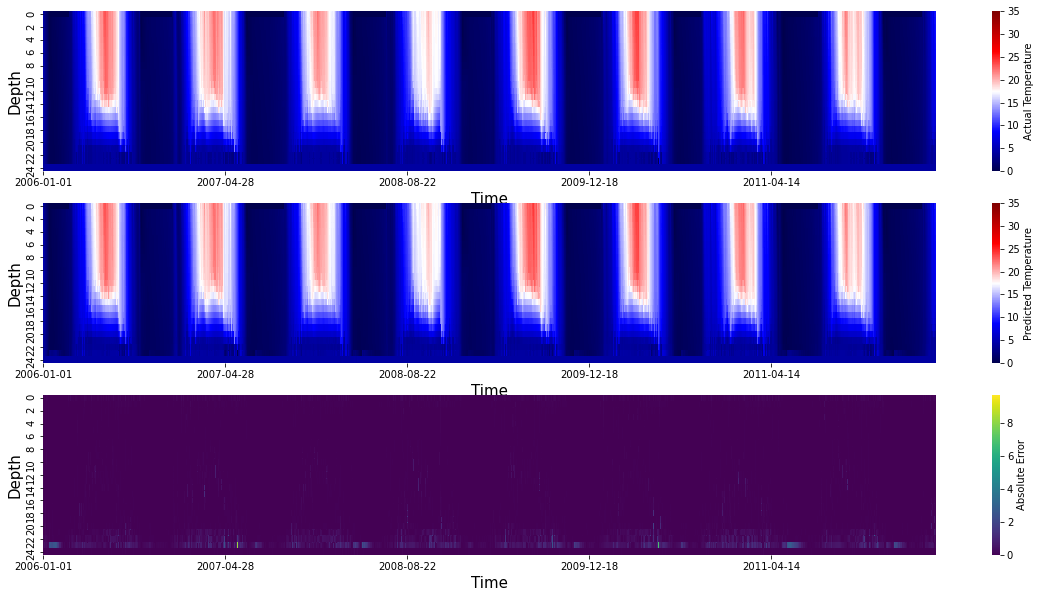

In [25]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

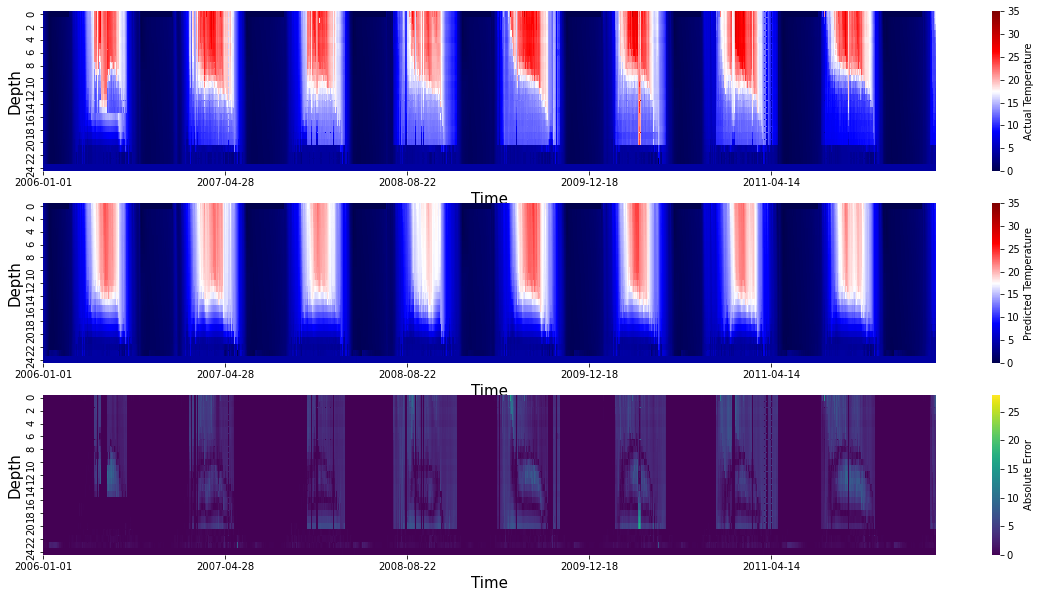

In [26]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [27]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.00040685644
RMSE of after m1 0.70851576
RMSE of after m2 0.7160733
RMSE of after m3 0.103591636
RMSE of after m4 0.10361398
RMSE of after m0 0.00038437784
RMSE of after m1 0.6898497
RMSE of after m2 0.6977635
RMSE of after m3 0.099296585
RMSE of after m4 0.099304296
RMSE of after m0 0.0004228058
RMSE of after m1 0.67883325
RMSE of after m2 0.68519497
RMSE of after m3 0.11355666
RMSE of after m4 0.113571346
RMSE of after m0 0.00046273702
RMSE of after m1 0.68441147
RMSE of after m2 0.69334203
RMSE of after m3 0.11508511
RMSE of after m4 0.11509195
RMSE of after m0 0.00039467865
RMSE of after m1 0.6994464
RMSE of after m2 0.7012198
RMSE of after m3 0.13000344
RMSE of after m4 0.13002227
RMSE of after m0 0.00052658113
RMSE of after m1 0.6667265
RMSE of after m2 0.671066
RMSE of after m3 0.14363116
RMSE of after m4 0.14364527
RMSE of after m0 0.0005018738
RMSE of after m1 0.6667033
RMSE of after m2 0.6747566
RMSE of after m3 0.11056684
RMSE of after m4 0.11057827
RMSE of

RMSE of after m2 0.6027507
RMSE of after m3 0.24730754
RMSE of after m4 0.24734125
RMSE of after m0 0.0011532014
RMSE of after m1 0.63619417
RMSE of after m2 0.6264727
RMSE of after m3 0.2623063
RMSE of after m4 0.26235238
RMSE of after m0 0.0013080611
RMSE of after m1 0.64700353
RMSE of after m2 0.6424171
RMSE of after m3 0.2602267
RMSE of after m4 0.2602795
RMSE of after m0 0.0013135931
RMSE of after m1 0.6616044
RMSE of after m2 0.6551405
RMSE of after m3 0.26054272
RMSE of after m4 0.26059315
RMSE of after m0 0.0011701914
RMSE of after m1 0.65656495
RMSE of after m2 0.6520136
RMSE of after m3 0.25359118
RMSE of after m4 0.2536555
RMSE of after m0 0.0010647479
RMSE of after m1 0.6782447
RMSE of after m2 0.675835
RMSE of after m3 0.2554941
RMSE of after m4 0.25556058
RMSE of after m0 0.00091831683
RMSE of after m1 0.67913646
RMSE of after m2 0.67905617
RMSE of after m3 0.24713291
RMSE of after m4 0.24720481
RMSE of after m0 0.0010713082
RMSE of after m1 0.6496247
RMSE of after m2 0.6

RMSE of after m0 0.00034850588
RMSE of after m1 0.10033601
RMSE of after m2 0.10106679
RMSE of after m3 0.055580325
RMSE of after m4 0.05565455
RMSE of after m0 0.00039162496
RMSE of after m1 0.10306178
RMSE of after m2 0.10429306
RMSE of after m3 0.019389162
RMSE of after m4 0.019679345
RMSE of after m0 0.00035013154
RMSE of after m1 0.104852796
RMSE of after m2 0.10613111
RMSE of after m3 0.029825741
RMSE of after m4 0.030064188
RMSE of after m0 0.0004039989
RMSE of after m1 0.106482714
RMSE of after m2 0.107335985
RMSE of after m3 0.05069158
RMSE of after m4 0.05103937
RMSE of after m0 0.00032426146
RMSE of after m1 0.11027004
RMSE of after m2 0.11086979
RMSE of after m3 0.066251576
RMSE of after m4 0.06655344
RMSE of after m0 0.0003002071
RMSE of after m1 0.11228399
RMSE of after m2 0.113076285
RMSE of after m3 0.07237392
RMSE of after m4 0.0728089
RMSE of after m0 0.00034151407
RMSE of after m1 0.11648912
RMSE of after m2 0.117413506
RMSE of after m3 0.25144064
RMSE of after m4 0.

RMSE of after m0 0.00032399377
RMSE of after m1 0.37626174
RMSE of after m2 0.24552095
RMSE of after m3 0.056384694
RMSE of after m4 0.056634676
RMSE of after m0 0.0002323085
RMSE of after m1 0.4058848
RMSE of after m2 0.25135854
RMSE of after m3 0.052948505
RMSE of after m4 0.053316228
RMSE of after m0 0.00027001742
RMSE of after m1 0.40407598
RMSE of after m2 0.37773195
RMSE of after m3 0.06651361
RMSE of after m4 0.06681437
RMSE of after m0 0.00026169073
RMSE of after m1 0.42485243
RMSE of after m2 0.18340851
RMSE of after m3 0.049246747
RMSE of after m4 0.049526505
RMSE of after m0 0.00026877175
RMSE of after m1 0.4459833
RMSE of after m2 0.38169414
RMSE of after m3 0.07888905
RMSE of after m4 0.079101324
RMSE of after m0 0.0002687226
RMSE of after m1 0.47645605
RMSE of after m2 0.27806118
RMSE of after m3 0.07347791
RMSE of after m4 0.07363877
RMSE of after m0 0.0002905517
RMSE of after m1 0.5018131
RMSE of after m2 0.22255866
RMSE of after m3 0.07558192
RMSE of after m4 0.0757153

RMSE of after m0 0.0015394657
RMSE of after m1 0.78971744
RMSE of after m2 0.81351864
RMSE of after m3 0.15044971
RMSE of after m4 0.15046485
RMSE of after m0 0.0015661425
RMSE of after m1 0.7848205
RMSE of after m2 0.81794935
RMSE of after m3 0.19043092
RMSE of after m4 0.19045506
RMSE of after m0 0.0014075863
RMSE of after m1 0.7298775
RMSE of after m2 0.7846456
RMSE of after m3 0.2854029
RMSE of after m4 0.28545254
RMSE of after m0 0.0014071207
RMSE of after m1 0.4618855
RMSE of after m2 0.44901899
RMSE of after m3 0.2962369
RMSE of after m4 0.29627714
RMSE of after m0 0.0011317956
RMSE of after m1 0.47054964
RMSE of after m2 0.43876883
RMSE of after m3 0.23715393
RMSE of after m4 0.23719624
RMSE of after m0 0.0010966426
RMSE of after m1 0.4578789
RMSE of after m2 0.43363127
RMSE of after m3 0.25500363
RMSE of after m4 0.25504598
RMSE of after m0 0.0009742876
RMSE of after m1 0.51869565
RMSE of after m2 0.49533883
RMSE of after m3 0.23741801
RMSE of after m4 0.23743586
RMSE of after

RMSE of after m3 0.2134682
RMSE of after m4 0.21350256
RMSE of after m0 0.0002975087
RMSE of after m1 1.1680342
RMSE of after m2 0.5031086
RMSE of after m3 0.2029749
RMSE of after m4 0.202917
RMSE of after m0 0.00048744958
RMSE of after m1 1.1870356
RMSE of after m2 0.5180467
RMSE of after m3 0.18776374
RMSE of after m4 0.18767126
RMSE of after m0 0.0002933542
RMSE of after m1 1.1241103
RMSE of after m2 0.91446906
RMSE of after m3 0.25689718
RMSE of after m4 0.25678712
RMSE of after m0 0.00020761682
RMSE of after m1 1.1700646
RMSE of after m2 0.58542144
RMSE of after m3 0.2168693
RMSE of after m4 0.21671236
RMSE of after m0 0.00030914828
RMSE of after m1 1.1572645
RMSE of after m2 0.16625983
RMSE of after m3 0.2015026
RMSE of after m4 0.20133147
RMSE of after m0 0.00054145575
RMSE of after m1 1.0692602
RMSE of after m2 0.47202945
RMSE of after m3 0.22341333
RMSE of after m4 0.223234
RMSE of after m0 0.00042097937
RMSE of after m1 0.7933567
RMSE of after m2 0.62427
RMSE of after m3 0.22

RMSE of after m1 0.19189131
RMSE of after m2 0.1917355
RMSE of after m3 0.03362936
RMSE of after m4 0.03380038
RMSE of after m0 0.000312751
RMSE of after m1 0.1987107
RMSE of after m2 0.196602
RMSE of after m3 0.020996805
RMSE of after m4 0.020533862
RMSE of after m0 0.0002520267
RMSE of after m1 0.20354658
RMSE of after m2 0.20085934
RMSE of after m3 0.018577201
RMSE of after m4 0.018291064
RMSE of after m0 0.00025231278
RMSE of after m1 0.20776588
RMSE of after m2 0.2078238
RMSE of after m3 0.018669643
RMSE of after m4 0.01820326
RMSE of after m0 0.00023642044
RMSE of after m1 0.21280651
RMSE of after m2 0.2132801
RMSE of after m3 0.021667793
RMSE of after m4 0.0215076
RMSE of after m0 0.00029461796
RMSE of after m1 0.21867545
RMSE of after m2 0.2176968
RMSE of after m3 0.02069152
RMSE of after m4 0.020499172
RMSE of after m0 0.0003383256
RMSE of after m1 0.22704008
RMSE of after m2 0.22415103
RMSE of after m3 0.026149414
RMSE of after m4 0.025582202
RMSE of after m0 0.00045759956
RM

RMSE of after m0 0.00057975104
RMSE of after m1 0.7433
RMSE of after m2 0.74970436
RMSE of after m3 0.18703146
RMSE of after m4 0.18703625
RMSE of after m0 0.00046952683
RMSE of after m1 0.76190037
RMSE of after m2 0.7743712
RMSE of after m3 0.15516378
RMSE of after m4 0.15517169
RMSE of after m0 0.00066706777
RMSE of after m1 0.7624034
RMSE of after m2 0.77042955
RMSE of after m3 0.14684516
RMSE of after m4 0.14686118
RMSE of after m0 0.0006589383
RMSE of after m1 0.78622806
RMSE of after m2 0.791489
RMSE of after m3 0.0980224
RMSE of after m4 0.09804212
RMSE of after m0 0.00060520513
RMSE of after m1 0.7642651
RMSE of after m2 0.7760078
RMSE of after m3 0.11377366
RMSE of after m4 0.11380423
RMSE of after m0 0.000810209
RMSE of after m1 0.73732966
RMSE of after m2 0.74575585
RMSE of after m3 0.10644394
RMSE of after m4 0.10647959
RMSE of after m0 0.00083829096
RMSE of after m1 0.72032773
RMSE of after m2 0.7276193
RMSE of after m3 0.10886609
RMSE of after m4 0.108894885
RMSE of after

RMSE of after m0 0.0011523005
RMSE of after m1 0.70356315
RMSE of after m2 0.7019667
RMSE of after m3 0.22995383
RMSE of after m4 0.23002003
RMSE of after m0 0.0010524251
RMSE of after m1 0.7014856
RMSE of after m2 0.7011646
RMSE of after m3 0.22983564
RMSE of after m4 0.22988646
RMSE of after m0 0.0009601475
RMSE of after m1 0.70497906
RMSE of after m2 0.7041098
RMSE of after m3 0.22938514
RMSE of after m4 0.22943696
RMSE of after m0 0.0010006583
RMSE of after m1 0.71734935
RMSE of after m2 0.7195272
RMSE of after m3 0.22232562
RMSE of after m4 0.2223802
RMSE of after m0 0.0010765047
RMSE of after m1 0.7356373
RMSE of after m2 0.738447
RMSE of after m3 0.2176602
RMSE of after m4 0.21771349
RMSE of after m0 0.001500663
RMSE of after m1 0.7176633
RMSE of after m2 0.75846183
RMSE of after m3 0.31212848
RMSE of after m4 0.31217003
RMSE of after m0 0.001156391
RMSE of after m1 0.6643923
RMSE of after m2 0.6613383
RMSE of after m3 0.24794748
RMSE of after m4 0.24798957
RMSE of after m0 0.00

RMSE of after m0 0.00024761542
RMSE of after m1 0.16019902
RMSE of after m2 0.16731699
RMSE of after m3 0.0965506
RMSE of after m4 0.096325405
RMSE of after m0 0.0002592915
RMSE of after m1 0.16264732
RMSE of after m2 0.16637187
RMSE of after m3 0.089378215
RMSE of after m4 0.0892207
RMSE of after m0 0.00022437681
RMSE of after m1 0.1645701
RMSE of after m2 0.16581689
RMSE of after m3 0.08158245
RMSE of after m4 0.081562616
RMSE of after m0 0.00025744122
RMSE of after m1 0.1672562
RMSE of after m2 0.16967091
RMSE of after m3 0.07418815
RMSE of after m4 0.07405774
RMSE of after m0 0.00026946887
RMSE of after m1 0.16889273
RMSE of after m2 0.17153008
RMSE of after m3 0.065960996
RMSE of after m4 0.065721035
RMSE of after m0 0.0002717447
RMSE of after m1 0.1716924
RMSE of after m2 0.1749974
RMSE of after m3 0.05297949
RMSE of after m4 0.05244057
RMSE of after m0 0.0003036346
RMSE of after m1 0.17555532
RMSE of after m2 0.17910133
RMSE of after m3 0.046961688
RMSE of after m4 0.046563867
R

RMSE of after m0 0.00020998396
RMSE of after m1 0.80539566
RMSE of after m2 0.6432753
RMSE of after m3 0.16540319
RMSE of after m4 0.16546822
RMSE of after m0 0.00020892933
RMSE of after m1 0.9382403
RMSE of after m2 0.3214778
RMSE of after m3 0.19234513
RMSE of after m4 0.19238476
RMSE of after m0 0.00018773947
RMSE of after m1 0.96517295
RMSE of after m2 0.3288231
RMSE of after m3 0.20269029
RMSE of after m4 0.20272289
RMSE of after m0 0.00020459472
RMSE of after m1 0.8176236
RMSE of after m2 0.62479633
RMSE of after m3 0.16136016
RMSE of after m4 0.16140823
RMSE of after m0 0.00022369814
RMSE of after m1 0.7069408
RMSE of after m2 0.7151361
RMSE of after m3 0.17485413
RMSE of after m4 0.17488015
RMSE of after m0 0.0002298047
RMSE of after m1 0.7500757
RMSE of after m2 0.67367274
RMSE of after m3 0.16338752
RMSE of after m4 0.1634282
RMSE of after m0 0.00025495514
RMSE of after m1 0.7262779
RMSE of after m2 0.696151
RMSE of after m3 0.14157344
RMSE of after m4 0.14161816
RMSE of afte

RMSE of after m0 0.0010942591
RMSE of after m1 0.79152656
RMSE of after m2 0.7978703
RMSE of after m3 0.08738163
RMSE of after m4 0.08737292
RMSE of after m0 0.001131162
RMSE of after m1 0.7690997
RMSE of after m2 0.7745391
RMSE of after m3 0.09643886
RMSE of after m4 0.09644148
RMSE of after m0 0.0011380609
RMSE of after m1 0.7440866
RMSE of after m2 0.7515159
RMSE of after m3 0.108265996
RMSE of after m4 0.10828419
RMSE of after m0 0.0011002817
RMSE of after m1 0.73433644
RMSE of after m2 0.7398257
RMSE of after m3 0.092919156
RMSE of after m4 0.092966594
RMSE of after m0 0.0010641649
RMSE of after m1 0.7388456
RMSE of after m2 0.743404
RMSE of after m3 0.08549875
RMSE of after m4 0.0855252
RMSE of after m0 0.0009968217
RMSE of after m1 0.74217266
RMSE of after m2 0.7464485
RMSE of after m3 0.08634497
RMSE of after m4 0.08638103
RMSE of after m0 0.001057224
RMSE of after m1 0.7434871
RMSE of after m2 0.7549305
RMSE of after m3 0.12934175
RMSE of after m4 0.12937625
RMSE of after m0 0

RMSE of after m0 0.00015857584
RMSE of after m1 0.75532717
RMSE of after m2 0.57903326
RMSE of after m3 0.15823804
RMSE of after m4 0.15828095
RMSE of after m0 0.00018059656
RMSE of after m1 0.72745526
RMSE of after m2 0.27075213
RMSE of after m3 0.09213556
RMSE of after m4 0.09222302
RMSE of after m0 0.0001623464
RMSE of after m1 0.7361459
RMSE of after m2 0.44516316
RMSE of after m3 0.0971894
RMSE of after m4 0.09725124
RMSE of after m0 0.00017618957
RMSE of after m1 0.69592816
RMSE of after m2 0.22651863
RMSE of after m3 0.088511854
RMSE of after m4 0.08860859
RMSE of after m0 0.00018171579
RMSE of after m1 0.63540715
RMSE of after m2 0.112559
RMSE of after m3 0.08882667
RMSE of after m4 0.08889165
RMSE of after m0 0.00022670113
RMSE of after m1 0.5681022
RMSE of after m2 0.40492743
RMSE of after m3 0.09828161
RMSE of after m4 0.09835172
RMSE of after m0 0.00021758495
RMSE of after m1 0.48840395
RMSE of after m2 0.33875477
RMSE of after m3 0.09413356
RMSE of after m4 0.09411688
RMSE

RMSE of after m1 0.22430101
RMSE of after m2 0.22738977
RMSE of after m3 0.04253272
RMSE of after m4 0.03972262
RMSE of after m0 0.0002923182
RMSE of after m1 0.2294663
RMSE of after m2 0.23173477
RMSE of after m3 0.03946095
RMSE of after m4 0.038049564
RMSE of after m0 0.00025542133
RMSE of after m1 0.23480956
RMSE of after m2 0.23736522
RMSE of after m3 0.038504515
RMSE of after m4 0.037978236
RMSE of after m0 0.00023886567
RMSE of after m1 0.24341099
RMSE of after m2 0.24345095
RMSE of after m3 0.03708698
RMSE of after m4 0.036649335
RMSE of after m0 0.00024835503
RMSE of after m1 0.24894561
RMSE of after m2 0.248255
RMSE of after m3 0.035511214
RMSE of after m4 0.034579884
RMSE of after m0 0.00020114963
RMSE of after m1 0.25272784
RMSE of after m2 0.25143778
RMSE of after m3 0.03201741
RMSE of after m4 0.031997927
RMSE of after m0 0.000221724
RMSE of after m1 0.25982496
RMSE of after m2 0.26087368
RMSE of after m3 0.028301612
RMSE of after m4 0.028218135
RMSE of after m0 0.00025570

RMSE of after m0 0.0009859289
RMSE of after m1 0.73913914
RMSE of after m2 0.7462795
RMSE of after m3 0.09639256
RMSE of after m4 0.096419215
RMSE of after m0 0.00097198796
RMSE of after m1 0.7386406
RMSE of after m2 0.7534531
RMSE of after m3 0.1333656
RMSE of after m4 0.1333783
RMSE of after m0 0.0009831027
RMSE of after m1 0.7415727
RMSE of after m2 0.748928
RMSE of after m3 0.09872562
RMSE of after m4 0.09874697
RMSE of after m0 0.0009274352
RMSE of after m1 0.74735534
RMSE of after m2 0.75640106
RMSE of after m3 0.116006844
RMSE of after m4 0.11601376
RMSE of after m0 0.00081937027
RMSE of after m1 0.7573562
RMSE of after m2 0.76910084
RMSE of after m3 0.10361429
RMSE of after m4 0.103609905
RMSE of after m0 0.0010155664
RMSE of after m1 0.7635625
RMSE of after m2 0.7762546
RMSE of after m3 0.12137345
RMSE of after m4 0.121394694
RMSE of after m0 0.00094014464
RMSE of after m1 0.7738254
RMSE of after m2 0.7796172
RMSE of after m3 0.08384347
RMSE of after m4 0.08384653
RMSE of afte

RMSE of after m0 0.0013676081
RMSE of after m1 0.5949772
RMSE of after m2 0.6172368
RMSE of after m3 0.23041987
RMSE of after m4 0.23043658
RMSE of after m0 0.00091854663
RMSE of after m1 0.61966074
RMSE of after m2 0.62390465
RMSE of after m3 0.110935755
RMSE of after m4 0.111019365
RMSE of after m0 0.00095049693
RMSE of after m1 0.54868394
RMSE of after m2 0.54614395
RMSE of after m3 0.13566405
RMSE of after m4 0.1357039
RMSE of after m0 0.0008471033
RMSE of after m1 0.6068146
RMSE of after m2 0.61063665
RMSE of after m3 0.11875435
RMSE of after m4 0.118817605
RMSE of after m0 0.0006867812
RMSE of after m1 0.58404845
RMSE of after m2 0.58550036
RMSE of after m3 0.11754332
RMSE of after m4 0.11763474
RMSE of after m0 0.00077226234
RMSE of after m1 0.9456107
RMSE of after m2 0.7444124
RMSE of after m3 0.5847583
RMSE of after m4 0.56848794
RMSE of after m0 0.00060596614
RMSE of after m1 0.84457904
RMSE of after m2 0.8721257
RMSE of after m3 0.3978293
RMSE of after m4 0.34039482
RMSE of 

RMSE of after m4 0.019458435
RMSE of after m0 0.00025226397
RMSE of after m1 0.19322263
RMSE of after m2 0.19449197
RMSE of after m3 0.018057702
RMSE of after m4 0.018164385
RMSE of after m0 0.00025410365
RMSE of after m1 0.19722162
RMSE of after m2 0.19851056
RMSE of after m3 0.020107483
RMSE of after m4 0.02017564
RMSE of after m0 0.00021871566
RMSE of after m1 0.20015854
RMSE of after m2 0.20093095
RMSE of after m3 0.02308869
RMSE of after m4 0.022988932
RMSE of after m0 0.0002223927
RMSE of after m1 0.20239478
RMSE of after m2 0.20610169
RMSE of after m3 0.028589372
RMSE of after m4 0.028428921
RMSE of after m0 0.00043683124
RMSE of after m1 0.20482479
RMSE of after m2 0.2080615
RMSE of after m3 0.027608592
RMSE of after m4 0.027403845
RMSE of after m0 0.00020909727
RMSE of after m1 0.20901304
RMSE of after m2 0.21157902
RMSE of after m3 0.032399535
RMSE of after m4 0.03232695
RMSE of after m0 0.00019053287
RMSE of after m1 0.21099
RMSE of after m2 0.21225235
RMSE of after m3 0.034

RMSE of after m1 0.9851192
RMSE of after m2 0.68388945
RMSE of after m3 0.19593744
RMSE of after m4 0.19596685
RMSE of after m0 0.00026989833
RMSE of after m1 0.95147413
RMSE of after m2 0.5454745
RMSE of after m3 0.1956505
RMSE of after m4 0.19568862
RMSE of after m0 0.00038499988
RMSE of after m1 0.9694698
RMSE of after m2 0.7359422
RMSE of after m3 0.2186983
RMSE of after m4 0.21873555
RMSE of after m0 0.00032076842
RMSE of after m1 0.7853299
RMSE of after m2 0.74668217
RMSE of after m3 0.19273312
RMSE of after m4 0.19275002
RMSE of after m0 0.00036965733
RMSE of after m1 0.73491764
RMSE of after m2 0.74285007
RMSE of after m3 0.106712475
RMSE of after m4 0.10673579
RMSE of after m0 0.00033796253
RMSE of after m1 0.73645145
RMSE of after m2 0.75391394
RMSE of after m3 0.20289077
RMSE of after m4 0.20289974
RMSE of after m0 0.0004071521
RMSE of after m1 0.6756414
RMSE of after m2 0.6828013
RMSE of after m3 0.11680299
RMSE of after m4 0.11680796
RMSE of after m0 0.000403884
RMSE of af

RMSE of after m0 0.0009972386
RMSE of after m1 0.67548907
RMSE of after m2 0.67201775
RMSE of after m3 0.25489676
RMSE of after m4 0.2549557
RMSE of after m0 0.0009449474
RMSE of after m1 0.69421744
RMSE of after m2 0.69402194
RMSE of after m3 0.2387805
RMSE of after m4 0.23883349
RMSE of after m0 0.0009265425
RMSE of after m1 0.7031542
RMSE of after m2 0.7162384
RMSE of after m3 0.26647407
RMSE of after m4 0.26651785
RMSE of after m0 0.0011612576
RMSE of after m1 0.69131947
RMSE of after m2 0.690838
RMSE of after m3 0.24385695
RMSE of after m4 0.24392244
RMSE of after m0 0.0012165706
RMSE of after m1 0.68608713
RMSE of after m2 0.70511925
RMSE of after m3 0.27840793
RMSE of after m4 0.27846205
RMSE of after m0 0.001166747
RMSE of after m1 0.6591871
RMSE of after m2 0.65409094
RMSE of after m3 0.26390082
RMSE of after m4 0.2639486
RMSE of after m0 0.0010234838
RMSE of after m1 0.6368431
RMSE of after m2 0.62792313
RMSE of after m3 0.25506613
RMSE of after m4 0.25510922
RMSE of after m0

Test RMSE Simulated: 0.18756189942359924
Test RMSE Observed Temp: 2.490877389907837
test L2 Error: 0.018244870007038116
The RMSEs after each modelling stage: [0.00059121 0.53857966 0.50680347 0.15262977 0.15178969]


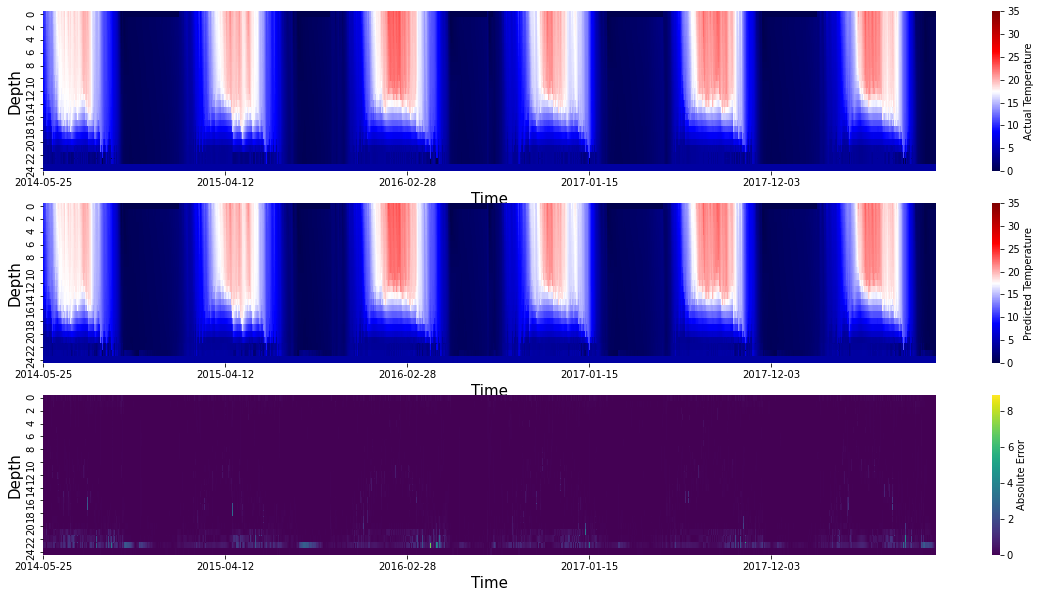

In [28]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

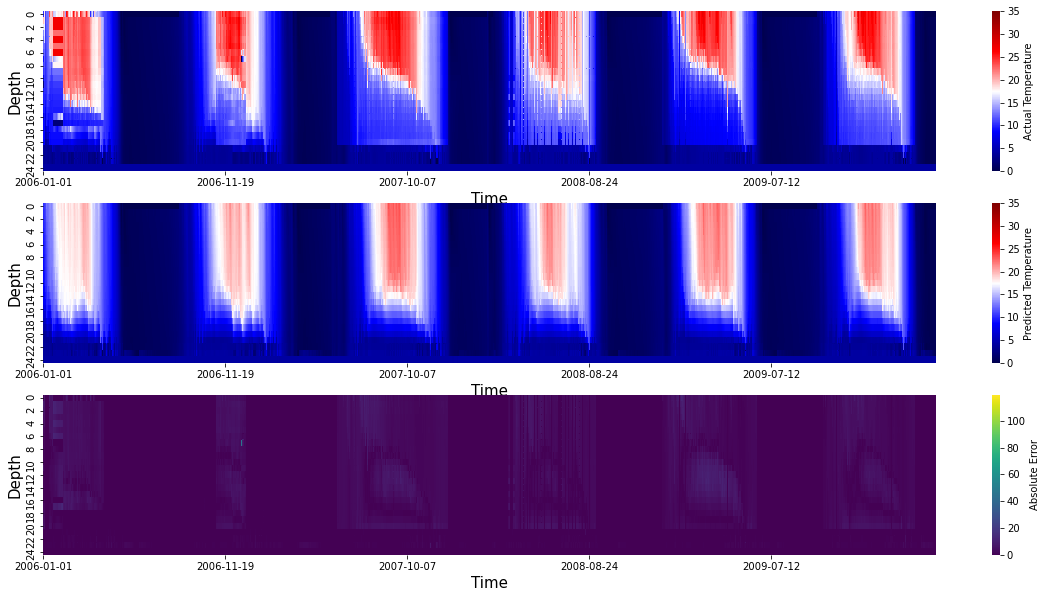

In [29]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [30]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 11.395342155022304, Train L2 Error: 1.1868947968576393
Test RMSE: 12.028427025260507, Train L2 Error: 1.1740138800862012


## Mixing Model

In [31]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.11018267930181727, Train L2 Error: 0.011469719278175432
Test RMSE: 0.121947361205087, Train L2 Error: 0.011897466396861693


## Convection Model

In [32]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.10238946186873105, Train L2 Error: 0.010641804283639112
Test RMSE: 0.11916663876987295, Train L2 Error: 0.011609599613482435


## Ice Model

In [33]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0011646093493033137, Train L2 Error: 0.00012104342580499258
Test RMSE: 0.0022081818962783406, Train L2 Error: 0.00021512855883762218


# Finetuning

In [34]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [35]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [36]:
#freeze_model(heating_model)
unfreeze_model(heating_model)
freeze_model(heat_diff_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [37]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
                
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:26<3:42:23, 26.74s/it]

Epoch : 0, Train_loss: 0.0982027532914427, Loss m0: 0.0040753013537246675, Loss m1: 0.013193825237344161, Loss m2: 0.011930688714036202, Loss m3: 0.005282534611981883, Loss m4: 0.0982027532914427


 10%|█         | 51/500 [23:08<3:21:44, 26.96s/it]

Epoch : 50, Train_loss: 0.055796611618556514, Loss m0: 0.05055050545538704, Loss m1: 0.06046838694582339, Loss m2: 0.05923618656431601, Loss m3: 0.05388811827144467, Loss m4: 0.055796611618556514


 20%|██        | 101/500 [45:47<2:59:59, 27.07s/it]

Epoch : 100, Train_loss: 0.049917077184782895, Loss m0: 0.058555959566468155, Loss m1: 0.06793504652257822, Loss m2: 0.06685079199731105, Loss m3: 0.06805996896812798, Loss m4: 0.049917077184782895


 30%|███       | 151/500 [1:08:26<2:38:47, 27.30s/it]

Epoch : 150, Train_loss: 0.048167355949060395, Loss m0: 0.06190977829754284, Loss m1: 0.07065085088706047, Loss m2: 0.06959879081911387, Loss m3: 0.07402602224137808, Loss m4: 0.048167355949060395


 40%|████      | 201/500 [1:31:11<2:15:08, 27.12s/it]

Epoch : 200, Train_loss: 0.04728240066892993, Loss m0: 0.06335434152286958, Loss m1: 0.07167383311968044, Loss m2: 0.07061746619371621, Loss m3: 0.07429575677190808, Loss m4: 0.04728240066892993


 50%|█████     | 251/500 [1:53:56<1:52:29, 27.11s/it]

Epoch : 250, Train_loss: 0.04673030554511807, Loss m0: 0.06421344215611063, Loss m1: 0.07230704753239242, Loss m2: 0.07119477659684692, Loss m3: 0.07254533778277619, Loss m4: 0.04673030554511807


 60%|██████    | 301/500 [2:16:37<1:31:17, 27.53s/it]

Epoch : 300, Train_loss: 0.046384098524705895, Loss m0: 0.06480389322608497, Loss m1: 0.07269392250847254, Loss m2: 0.07157898163838937, Loss m3: 0.07249437003576689, Loss m4: 0.046384098524705895


 70%|███████   | 351/500 [2:39:11<1:07:00, 26.99s/it]

Epoch : 350, Train_loss: 0.046127206407934704, Loss m0: 0.06519204610819503, Loss m1: 0.07299055018504631, Loss m2: 0.07184457803222873, Loss m3: 0.07199584723510508, Loss m4: 0.046127206407934704


 80%|████████  | 401/500 [3:01:55<45:31, 27.59s/it]  

Epoch : 400, Train_loss: 0.04593100869546027, Loss m0: 0.06547763183842345, Loss m1: 0.07316499547934813, Loss m2: 0.07201944519335444, Loss m3: 0.07221134894615439, Loss m4: 0.04593100869546027


 90%|█████████ | 451/500 [3:24:39<22:18, 27.31s/it]

Epoch : 450, Train_loss: 0.04577068035611339, Loss m0: 0.06571343770981754, Loss m1: 0.0733016240674972, Loss m2: 0.07216173300902996, Loss m3: 0.07253887109860523, Loss m4: 0.04577068035611339


100%|██████████| 500/500 [3:46:57<00:00, 27.24s/it]


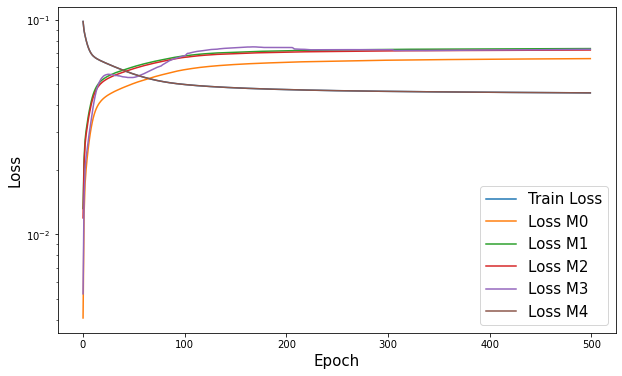

In [38]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

In [39]:
PATH = f"./saved_models/heating_model_finetuned.pth"
torch.save(heating_model.state_dict(), PATH)

# Rollout Evaluation After FineTuning

In [40]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.11926743
RMSE of after m1 0.792838
RMSE of after m2 0.41342786
RMSE of after m3 0.1754501
RMSE of after m4 0.175246
RMSE of after m0 0.13352291
RMSE of after m1 0.7128937
RMSE of after m2 0.6632337
RMSE of after m3 0.1882075
RMSE of after m4 0.18819782
RMSE of after m0 0.1814722
RMSE of after m1 0.71611047
RMSE of after m2 0.24302356
RMSE of after m3 0.17240538
RMSE of after m4 0.17271955
RMSE of after m0 0.2659258
RMSE of after m1 0.72971576
RMSE of after m2 0.5645385
RMSE of after m3 0.25474504
RMSE of after m4 0.25577217
RMSE of after m0 0.3040877
RMSE of after m1 0.6680783
RMSE of after m2 0.5135584
RMSE of after m3 0.2877454
RMSE of after m4 0.28848094
RMSE of after m0 0.32511058
RMSE of after m1 0.6303448
RMSE of after m2 0.5495412
RMSE of after m3 0.30817315
RMSE of after m4 0.30822667
RMSE of after m0 0.31512013
RMSE of after m1 0.57143027
RMSE of after m2 0.4945715
RMSE of after m3 0.3000898
RMSE of after m4 0.29984662
RMSE of after m0 0.28008166
RMSE of aft

RMSE of after m0 1.6347022
RMSE of after m1 1.7770411
RMSE of after m2 1.7631072
RMSE of after m3 1.6278404
RMSE of after m4 1.628551
RMSE of after m0 1.5003537
RMSE of after m1 1.6937077
RMSE of after m2 1.6411663
RMSE of after m3 1.5012763
RMSE of after m4 1.5019755
RMSE of after m0 1.44598
RMSE of after m1 1.6071266
RMSE of after m2 1.6043315
RMSE of after m3 1.4491858
RMSE of after m4 1.4498354
RMSE of after m0 1.7044032
RMSE of after m1 1.8761837
RMSE of after m2 1.7946142
RMSE of after m3 1.700204
RMSE of after m4 1.7008706
RMSE of after m0 1.9743811
RMSE of after m1 2.122285
RMSE of after m2 2.111157
RMSE of after m3 1.9728222
RMSE of after m4 1.973547
RMSE of after m0 1.7501954
RMSE of after m1 2.1150112
RMSE of after m2 1.7386136
RMSE of after m3 1.7230612
RMSE of after m4 1.7237403
RMSE of after m0 1.4887193
RMSE of after m1 1.6999971
RMSE of after m2 1.6808974
RMSE of after m3 1.5116439
RMSE of after m4 1.5121666
RMSE of after m0 1.6683413
RMSE of after m1 1.9225695
RMSE of 

RMSE of after m0 2.4059002
RMSE of after m1 2.5433671
RMSE of after m2 2.5499134
RMSE of after m3 2.4122179
RMSE of after m4 2.412255
RMSE of after m0 2.1954525
RMSE of after m1 2.3437736
RMSE of after m2 2.3474839
RMSE of after m3 2.1997662
RMSE of after m4 2.1998608
RMSE of after m0 2.3313594
RMSE of after m1 2.4709647
RMSE of after m2 2.4779482
RMSE of after m3 2.3392994
RMSE of after m4 2.3393958
RMSE of after m0 2.2959101
RMSE of after m1 2.4436395
RMSE of after m2 2.451902
RMSE of after m3 2.3054783
RMSE of after m4 2.3055625
RMSE of after m0 2.2144263
RMSE of after m1 2.3601942
RMSE of after m2 2.3680396
RMSE of after m3 2.2258997
RMSE of after m4 2.226008
RMSE of after m0 2.2283857
RMSE of after m1 2.3662853
RMSE of after m2 2.3738456
RMSE of after m3 2.2406466
RMSE of after m4 2.2407994
RMSE of after m0 2.3135328
RMSE of after m1 2.443328
RMSE of after m2 2.4499354
RMSE of after m3 2.3246806
RMSE of after m4 2.3248217
RMSE of after m0 2.268383
RMSE of after m1 2.4037983
RMSE o

RMSE of after m2 0.27885512
RMSE of after m3 0.24534479
RMSE of after m4 0.2445657
RMSE of after m0 0.24173497
RMSE of after m1 0.27761778
RMSE of after m2 0.27593824
RMSE of after m3 0.24875382
RMSE of after m4 0.24838115
RMSE of after m0 0.23507904
RMSE of after m1 0.27153966
RMSE of after m2 0.27476913
RMSE of after m3 0.24821898
RMSE of after m4 0.24726981
RMSE of after m0 0.19169575
RMSE of after m1 0.24331586
RMSE of after m2 0.2437272
RMSE of after m3 0.20934437
RMSE of after m4 0.20908257
RMSE of after m0 0.25456643
RMSE of after m1 0.28171647
RMSE of after m2 0.28321043
RMSE of after m3 0.26613984
RMSE of after m4 0.26570353
RMSE of after m0 0.2783177
RMSE of after m1 0.29756734
RMSE of after m2 0.29676968
RMSE of after m3 0.28411195
RMSE of after m4 0.28369927
RMSE of after m0 0.20268741
RMSE of after m1 0.23772691
RMSE of after m2 0.23708048
RMSE of after m3 0.22130492
RMSE of after m4 0.22125086
RMSE of after m0 0.17874226
RMSE of after m1 0.22647162
RMSE of after m2 0.2234

RMSE of after m0 0.52854615
RMSE of after m1 0.69875103
RMSE of after m2 0.5964129
RMSE of after m3 0.5337189
RMSE of after m4 0.53411496
RMSE of after m0 0.39470825
RMSE of after m1 0.66612536
RMSE of after m2 0.5147108
RMSE of after m3 0.405922
RMSE of after m4 0.40634808
RMSE of after m0 0.46532091
RMSE of after m1 0.7415235
RMSE of after m2 0.5582371
RMSE of after m3 0.47171888
RMSE of after m4 0.47211397
RMSE of after m0 0.5234482
RMSE of after m1 0.8140651
RMSE of after m2 0.53462726
RMSE of after m3 0.5253401
RMSE of after m4 0.5257902
RMSE of after m0 0.5899415
RMSE of after m1 0.89130414
RMSE of after m2 0.7154848
RMSE of after m3 0.5997684
RMSE of after m4 0.6002024
RMSE of after m0 0.27736285
RMSE of after m1 0.7697131
RMSE of after m2 0.29027647
RMSE of after m3 0.26809385
RMSE of after m4 0.2684227
RMSE of after m0 0.1377444
RMSE of after m1 0.6523192
RMSE of after m2 0.16172405
RMSE of after m3 0.14232065
RMSE of after m4 0.14256851
RMSE of after m0 0.117673844
RMSE of af

RMSE of after m2 3.3224227
RMSE of after m3 3.2345855
RMSE of after m4 3.2345989
RMSE of after m0 3.1550405
RMSE of after m1 3.2360373
RMSE of after m2 3.238744
RMSE of after m3 3.1564023
RMSE of after m4 3.1563616
RMSE of after m0 3.0866685
RMSE of after m1 3.1699302
RMSE of after m2 3.1720905
RMSE of after m3 3.0887775
RMSE of after m4 3.088673
RMSE of after m0 2.8794484
RMSE of after m1 2.969763
RMSE of after m2 2.9726615
RMSE of after m3 2.8823898
RMSE of after m4 2.8824108
RMSE of after m0 2.8908763
RMSE of after m1 2.9809434
RMSE of after m2 2.9840524
RMSE of after m3 2.896115
RMSE of after m4 2.8961813
RMSE of after m0 3.0201066
RMSE of after m1 3.102041
RMSE of after m2 3.104311
RMSE of after m3 3.023912
RMSE of after m4 3.023953
RMSE of after m0 2.9926798
RMSE of after m1 3.075664
RMSE of after m2 3.0790453
RMSE of after m3 2.9975138
RMSE of after m4 2.9975247
RMSE of after m0 2.998272
RMSE of after m1 3.092738
RMSE of after m2 3.0978384
RMSE of after m3 3.0003242
RMSE of afte

RMSE of after m3 2.7528346
RMSE of after m4 2.1967435
RMSE of after m0 2.1308842
RMSE of after m1 2.2280595
RMSE of after m2 2.2480671
RMSE of after m3 2.1660419
RMSE of after m4 2.1659002
RMSE of after m0 1.9976047
RMSE of after m1 2.5112343
RMSE of after m2 2.0664887
RMSE of after m3 2.028236
RMSE of after m4 2.0283911
RMSE of after m0 1.6599302
RMSE of after m1 1.8115647
RMSE of after m2 1.8265744
RMSE of after m3 1.690647
RMSE of after m4 1.691126
RMSE of after m0 1.5538126
RMSE of after m1 1.7260534
RMSE of after m2 1.7441406
RMSE of after m3 1.585914
RMSE of after m4 1.5864102
RMSE of after m0 1.8345227
RMSE of after m1 2.1490967
RMSE of after m2 2.0083916
RMSE of after m3 1.8549216
RMSE of after m4 1.8553786
RMSE of after m0 1.833569
RMSE of after m1 2.0280306
RMSE of after m2 1.9744042
RMSE of after m3 1.8495382
RMSE of after m4 1.8500316
RMSE of after m0 1.6279742
RMSE of after m1 2.013889
RMSE of after m2 1.7055634
RMSE of after m3 1.650459
RMSE of after m4 1.6508552
RMSE of 

RMSE of after m0 0.1362153
RMSE of after m1 0.2696023
RMSE of after m2 0.27212358
RMSE of after m3 0.13399945
RMSE of after m4 0.13338909
RMSE of after m0 0.14500694
RMSE of after m1 0.27870595
RMSE of after m2 0.28196648
RMSE of after m3 0.1426221
RMSE of after m4 0.14176689
RMSE of after m0 0.14646076
RMSE of after m1 0.27959886
RMSE of after m2 0.28234336
RMSE of after m3 0.14385061
RMSE of after m4 0.14378993
RMSE of after m0 0.16497172
RMSE of after m1 0.28741252
RMSE of after m2 0.28803536
RMSE of after m3 0.15810747
RMSE of after m4 0.15789996
RMSE of after m0 0.18560553
RMSE of after m1 0.29921767
RMSE of after m2 0.3009665
RMSE of after m3 0.1809548
RMSE of after m4 0.1801207
RMSE of after m0 0.15070711
RMSE of after m1 0.29328105
RMSE of after m2 0.29608703
RMSE of after m3 0.14720295
RMSE of after m4 0.14701936
RMSE of after m0 0.1469693
RMSE of after m1 0.2956041
RMSE of after m2 0.29765186
RMSE of after m3 0.14208102
RMSE of after m4 0.14085099
RMSE of after m0 0.14043269


RMSE of after m4 2.4890628
RMSE of after m0 2.4855075
RMSE of after m1 2.6090052
RMSE of after m2 2.609275
RMSE of after m3 2.4858513
RMSE of after m4 2.486629
RMSE of after m0 2.5050352
RMSE of after m1 2.6419024
RMSE of after m2 2.640741
RMSE of after m3 2.499893
RMSE of after m4 2.500571
RMSE of after m0 2.5704222
RMSE of after m1 2.708388
RMSE of after m2 2.7102168
RMSE of after m3 2.5669646
RMSE of after m4 2.5676632
RMSE of after m0 2.5349095
RMSE of after m1 2.6705704
RMSE of after m2 2.6713023
RMSE of after m3 2.5305755
RMSE of after m4 2.5312452
RMSE of after m0 2.547702
RMSE of after m1 2.6829362
RMSE of after m2 2.6836677
RMSE of after m3 2.5414245
RMSE of after m4 2.5418751
RMSE of after m0 2.593323
RMSE of after m1 2.7156014
RMSE of after m2 2.7164488
RMSE of after m3 2.5905685
RMSE of after m4 2.5909152
RMSE of after m0 2.598752
RMSE of after m1 2.7174225
RMSE of after m2 2.719732
RMSE of after m3 2.5973902
RMSE of after m4 2.5976818
RMSE of after m0 2.446613
RMSE of afte

RMSE of after m2 2.2379649
RMSE of after m3 2.1218374
RMSE of after m4 2.122027
RMSE of after m0 2.1354764
RMSE of after m1 2.2798033
RMSE of after m2 2.2928588
RMSE of after m3 2.1640124
RMSE of after m4 2.1641045
RMSE of after m0 2.3185024
RMSE of after m1 2.4693708
RMSE of after m2 2.4866438
RMSE of after m3 2.3434708
RMSE of after m4 2.3434505
RMSE of after m0 2.1626456
RMSE of after m1 2.2346578
RMSE of after m2 2.2418764
RMSE of after m3 2.1835485
RMSE of after m4 2.1834464
RMSE of after m0 2.2191503
RMSE of after m1 2.352891
RMSE of after m2 2.4058897
RMSE of after m3 2.3014371
RMSE of after m4 2.3013206
RMSE of after m0 2.234593
RMSE of after m1 2.379794
RMSE of after m2 2.3992703
RMSE of after m3 3.205499
RMSE of after m4 2.2772753
RMSE of after m0 2.2922904
RMSE of after m1 2.6349099
RMSE of after m2 2.417949
RMSE of after m3 3.2167761
RMSE of after m4 2.370884
RMSE of after m0 2.0141232
RMSE of after m1 2.4128091
RMSE of after m2 2.1614888
RMSE of after m3 2.0853028
RMSE of 

RMSE of after m4 0.1515937
RMSE of after m0 0.14706339
RMSE of after m1 0.23069969
RMSE of after m2 0.23049983
RMSE of after m3 0.1409678
RMSE of after m4 0.13044783
RMSE of after m0 0.14988102
RMSE of after m1 0.23440461
RMSE of after m2 0.2345991
RMSE of after m3 0.1430587
RMSE of after m4 0.12907894
RMSE of after m0 0.13364589
RMSE of after m1 0.22929247
RMSE of after m2 0.22932403
RMSE of after m3 0.12005376
RMSE of after m4 0.11857654
RMSE of after m0 0.15850401
RMSE of after m1 0.24687268
RMSE of after m2 0.24773513
RMSE of after m3 0.14735216
RMSE of after m4 0.118308276
RMSE of after m0 0.16949601
RMSE of after m1 0.25125965
RMSE of after m2 0.25067446
RMSE of after m3 0.15687524
RMSE of after m4 0.13726792
RMSE of after m0 0.14306031
RMSE of after m1 0.24090776
RMSE of after m2 0.24150398
RMSE of after m3 0.12874617
RMSE of after m4 0.124063335
RMSE of after m0 0.14827257
RMSE of after m1 0.24925669
RMSE of after m2 0.24869652
RMSE of after m3 0.13159056
RMSE of after m4 0.129

RMSE of after m0 2.2403705
RMSE of after m1 2.3740368
RMSE of after m2 2.3790255
RMSE of after m3 2.2550719
RMSE of after m4 2.2554407
RMSE of after m0 2.2961478
RMSE of after m1 2.4178874
RMSE of after m2 2.4236863
RMSE of after m3 2.3070025
RMSE of after m4 2.3073714
RMSE of after m0 2.2431278
RMSE of after m1 2.341689
RMSE of after m2 2.3471408
RMSE of after m3 2.255785
RMSE of after m4 2.2561471
RMSE of after m0 2.3334773
RMSE of after m1 2.4142797
RMSE of after m2 2.419864
RMSE of after m3 2.347151
RMSE of after m4 2.347517
RMSE of after m0 2.3178763
RMSE of after m1 2.4091487
RMSE of after m2 2.414417
RMSE of after m3 2.330515
RMSE of after m4 2.3308659
RMSE of after m0 2.3966885
RMSE of after m1 2.5202763
RMSE of after m2 2.5281584
RMSE of after m3 2.4078205
RMSE of after m4 2.4082341
RMSE of after m0 2.3982332
RMSE of after m1 2.5032434
RMSE of after m2 2.50994
RMSE of after m3 2.410826
RMSE of after m4 2.4112537
RMSE of after m0 2.437914
RMSE of after m1 2.5219843
RMSE of afte

RMSE of after m0 2.218462
RMSE of after m1 2.3564746
RMSE of after m2 2.3658762
RMSE of after m3 2.2369428
RMSE of after m4 2.2372725
RMSE of after m0 2.1982093
RMSE of after m1 2.333641
RMSE of after m2 2.3407314
RMSE of after m3 2.2143683
RMSE of after m4 2.2147667
RMSE of after m0 2.2345164
RMSE of after m1 2.3647916
RMSE of after m2 2.3705451
RMSE of after m3 2.247489
RMSE of after m4 2.2479541
RMSE of after m0 2.1153998
RMSE of after m1 2.2719533
RMSE of after m2 2.2792113
RMSE of after m3 2.1260483
RMSE of after m4 2.1265557
RMSE of after m0 2.1747682
RMSE of after m1 2.335052
RMSE of after m2 2.3411534
RMSE of after m3 2.183444
RMSE of after m4 2.1840088
RMSE of after m0 2.2747083
RMSE of after m1 2.4186172
RMSE of after m2 2.4248803
RMSE of after m3 2.2822013
RMSE of after m4 2.282834
RMSE of after m0 2.2759833
RMSE of after m1 2.430322
RMSE of after m2 2.435571
RMSE of after m3 2.2819917
RMSE of after m4 2.282637
RMSE of after m0 2.235639
RMSE of after m1 2.380528
RMSE of afte

RMSE of after m0 0.14736024
RMSE of after m1 0.25575948
RMSE of after m2 0.25787172
RMSE of after m3 0.15354815
RMSE of after m4 0.13867126
RMSE of after m0 0.17133948
RMSE of after m1 0.26408044
RMSE of after m2 0.26483157
RMSE of after m3 0.17157632
RMSE of after m4 0.13262323
RMSE of after m0 0.16581152
RMSE of after m1 0.26791432
RMSE of after m2 0.26876906
RMSE of after m3 0.16937171
RMSE of after m4 0.13138188
RMSE of after m0 0.14252652
RMSE of after m1 0.25558653
RMSE of after m2 0.25628948
RMSE of after m3 0.14315009
RMSE of after m4 0.12361843
RMSE of after m0 0.13362013
RMSE of after m1 0.25201106
RMSE of after m2 0.25211272
RMSE of after m3 0.13074853
RMSE of after m4 0.119028024
RMSE of after m0 0.14470102
RMSE of after m1 0.25876737
RMSE of after m2 0.25965938
RMSE of after m3 0.14176716
RMSE of after m4 0.11788593
RMSE of after m0 0.1366985
RMSE of after m1 0.2581003
RMSE of after m2 0.25877476
RMSE of after m3 0.13242154
RMSE of after m4 0.11467819
RMSE of after m0 0.14

RMSE of after m4 1.0764723
RMSE of after m0 1.0807086
RMSE of after m1 1.3639469
RMSE of after m2 1.1652817
RMSE of after m3 1.1071587
RMSE of after m4 1.1074762
RMSE of after m0 0.94394225
RMSE of after m1 1.2009552
RMSE of after m2 1.1399083
RMSE of after m3 0.9644706
RMSE of after m4 0.9647916
RMSE of after m0 1.1476454
RMSE of after m1 1.408024
RMSE of after m2 1.2801543
RMSE of after m3 1.1727523
RMSE of after m4 1.1730866
RMSE of after m0 1.6121249
RMSE of after m1 1.8522735
RMSE of after m2 1.6700476
RMSE of after m3 1.5993384
RMSE of after m4 1.5999904
RMSE of after m0 1.6846265
RMSE of after m1 1.8423733
RMSE of after m2 1.7993557
RMSE of after m3 1.6665816
RMSE of after m4 1.6674062
RMSE of after m0 1.7275544
RMSE of after m1 1.9393489
RMSE of after m2 1.7891945
RMSE of after m3 1.697453
RMSE of after m4 1.6982698
RMSE of after m0 1.7700464
RMSE of after m1 1.9896681
RMSE of after m2 1.8359631
RMSE of after m3 1.7443897
RMSE of after m4 1.7452773
RMSE of after m0 1.6366043
RM

RMSE of after m0 3.1687267
RMSE of after m1 3.2822545
RMSE of after m2 3.2897487
RMSE of after m3 3.1678019
RMSE of after m4 3.1675572
RMSE of after m0 3.0676775
RMSE of after m1 3.1839387
RMSE of after m2 3.188783
RMSE of after m3 3.064556
RMSE of after m4 3.0642636
RMSE of after m0 2.7223027
RMSE of after m1 2.8479702
RMSE of after m2 2.8533175
RMSE of after m3 2.7230275
RMSE of after m4 2.7228363
RMSE of after m0 2.5238657
RMSE of after m1 2.646207
RMSE of after m2 2.6539285
RMSE of after m3 2.5286534
RMSE of after m4 2.5286248
RMSE of after m0 2.7737594
RMSE of after m1 2.8809538
RMSE of after m2 2.8857782
RMSE of after m3 2.7749474
RMSE of after m4 2.7749336
RMSE of after m0 2.9230962
RMSE of after m1 3.0234993
RMSE of after m2 3.0270724
RMSE of after m3 2.9246638
RMSE of after m4 2.9246333
RMSE of after m0 3.1542945
RMSE of after m1 3.2461267
RMSE of after m2 3.2530744
RMSE of after m3 3.1603935
RMSE of after m4 3.1603103
RMSE of after m0 3.2201462
RMSE of after m1 3.3122902
RMSE

RMSE of after m0 0.17182109
RMSE of after m1 0.20762098
RMSE of after m2 0.20877255
RMSE of after m3 0.18329747
RMSE of after m4 0.1835403
RMSE of after m0 0.16080034
RMSE of after m1 0.20268235
RMSE of after m2 0.2060308
RMSE of after m3 0.176809
RMSE of after m4 0.17394005
RMSE of after m0 0.16784844
RMSE of after m1 0.20905203
RMSE of after m2 0.20933357
RMSE of after m3 0.18423302
RMSE of after m4 0.18278827
RMSE of after m0 0.15887749
RMSE of after m1 0.20396285
RMSE of after m2 0.20522161
RMSE of after m3 0.17927483
RMSE of after m4 0.17501518
RMSE of after m0 0.1601218
RMSE of after m1 0.20772427
RMSE of after m2 0.20798619
RMSE of after m3 0.17943595
RMSE of after m4 0.17279771
RMSE of after m0 0.18532209
RMSE of after m1 0.21930897
RMSE of after m2 0.21362932
RMSE of after m3 0.20296054
RMSE of after m4 0.20286684
RMSE of after m0 0.19729751
RMSE of after m1 0.24875054
RMSE of after m2 0.24574709
RMSE of after m3 0.2180254
RMSE of after m4 0.21192333
RMSE of after m0 0.17122
R

RMSE of after m3 0.37355226
RMSE of after m4 0.37380743
RMSE of after m0 0.31275094
RMSE of after m1 0.7032503
RMSE of after m2 0.48814854
RMSE of after m3 0.32525444
RMSE of after m4 0.32544342
RMSE of after m0 0.25875515
RMSE of after m1 0.6506621
RMSE of after m2 0.52525437
RMSE of after m3 0.2776598
RMSE of after m4 0.27780733
RMSE of after m0 0.38477388
RMSE of after m1 0.6837503
RMSE of after m2 0.5085739
RMSE of after m3 0.39821756
RMSE of after m4 0.39833635
RMSE of after m0 0.53336084
RMSE of after m1 0.7669722
RMSE of after m2 0.71966153
RMSE of after m3 0.5438262
RMSE of after m4 0.5440075
RMSE of after m0 0.587663
RMSE of after m1 0.8233065
RMSE of after m2 0.69717836
RMSE of after m3 0.597851
RMSE of after m4 0.5980887
RMSE of after m0 0.6173677
RMSE of after m1 0.8746867
RMSE of after m2 0.8151822
RMSE of after m3 0.62833613
RMSE of after m4 0.62866956
RMSE of after m0 0.54687274
RMSE of after m1 0.857446
RMSE of after m2 0.75857955
RMSE of after m3 0.5606885
RMSE of afte

RMSE of after m0 2.8486826
RMSE of after m1 2.9661708
RMSE of after m2 2.9676232
RMSE of after m3 2.8380399
RMSE of after m4 2.8371093
RMSE of after m0 2.855794
RMSE of after m1 2.9742422
RMSE of after m2 2.9732065
RMSE of after m3 2.843643
RMSE of after m4 2.84274
RMSE of after m0 3.0080333
RMSE of after m1 3.1140847
RMSE of after m2 3.1145477
RMSE of after m3 2.9982274
RMSE of after m4 2.9971185
RMSE of after m0 3.1348608
RMSE of after m1 3.2335787
RMSE of after m2 3.2357671
RMSE of after m3 3.1255884
RMSE of after m4 3.1249278
RMSE of after m0 3.1918657
RMSE of after m1 3.2891715
RMSE of after m2 3.2910693
RMSE of after m3 3.1820588
RMSE of after m4 3.18138
RMSE of after m0 3.026436
RMSE of after m1 3.1298454
RMSE of after m2 3.1312263
RMSE of after m3 3.0167427
RMSE of after m4 3.0159903
RMSE of after m0 2.7257092
RMSE of after m1 2.8480256
RMSE of after m2 2.8583038
RMSE of after m3 2.7253897
RMSE of after m4 2.7248828
RMSE of after m0 3.0078492
RMSE of after m1 3.110657
RMSE of a

RMSE of after m1 1.0514095
RMSE of after m2 0.8475118
RMSE of after m3 0.765349
RMSE of after m4 0.765747
RMSE of after m0 0.8624312
RMSE of after m1 1.1176137
RMSE of after m2 1.0355189
RMSE of after m3 0.8761332
RMSE of after m4 0.87654877
RMSE of after m0 0.65939254
RMSE of after m1 0.90802574
RMSE of after m2 0.8833712
RMSE of after m3 0.6732351
RMSE of after m4 0.6734769
RMSE of after m0 0.69963473
RMSE of after m1 0.90105814
RMSE of after m2 0.87851375
RMSE of after m3 0.71203804
RMSE of after m4 0.7122465
RMSE of after m0 0.9171922
RMSE of after m1 1.0460789
RMSE of after m2 0.91367984
RMSE of after m3 0.9140332
RMSE of after m4 0.91441655
RMSE of after m0 0.9669469
RMSE of after m1 1.0985998
RMSE of after m2 0.9912569
RMSE of after m3 0.96396196
RMSE of after m4 0.96450204
RMSE of after m0 0.55013686
RMSE of after m1 0.75936776
RMSE of after m2 0.7128124
RMSE of after m3 0.5626103
RMSE of after m4 0.562798
RMSE of after m0 0.47943747
RMSE of after m1 0.6908542
RMSE of after m2 

RMSE of after m4 0.10917222
RMSE of after m0 0.11192425
RMSE of after m1 0.3227816
RMSE of after m2 0.3210465
RMSE of after m3 0.1065512
RMSE of after m4 0.10600828
RMSE of after m0 0.11325401
RMSE of after m1 0.3219732
RMSE of after m2 0.31845948
RMSE of after m3 0.10671213
RMSE of after m4 0.10104651
RMSE of after m0 0.12955883
RMSE of after m1 0.32970288
RMSE of after m2 0.32803065
RMSE of after m3 0.1228461
RMSE of after m4 0.112458974
RMSE of after m0 0.12843269
RMSE of after m1 0.3412845
RMSE of after m2 0.34085926
RMSE of after m3 0.12856208
RMSE of after m4 0.12426176
RMSE of after m0 0.11749127
RMSE of after m1 0.33505237
RMSE of after m2 0.33274627
RMSE of after m3 0.11449181
RMSE of after m4 0.11003716
RMSE of after m0 0.22705074
RMSE of after m1 0.35042548
RMSE of after m2 0.35187307
RMSE of after m3 0.21864678
RMSE of after m4 0.1732151
RMSE of after m0 0.1584687
RMSE of after m1 0.36213186
RMSE of after m2 0.35866553
RMSE of after m3 0.15030046
RMSE of after m4 0.13758104

RMSE of after m0 2.5759134
RMSE of after m1 2.6774695
RMSE of after m2 2.6798909
RMSE of after m3 2.578055
RMSE of after m4 2.5799305
RMSE of after m0 2.5881677
RMSE of after m1 2.6998377
RMSE of after m2 2.6954558
RMSE of after m3 2.590025
RMSE of after m4 2.5919633
RMSE of after m0 2.5266333
RMSE of after m1 2.6475236
RMSE of after m2 2.6468208
RMSE of after m3 2.5314307
RMSE of after m4 2.5328002
RMSE of after m0 2.5907552
RMSE of after m1 2.6350636
RMSE of after m2 2.6262348
RMSE of after m3 2.5875576
RMSE of after m4 2.5889447
RMSE of after m0 2.6378438
RMSE of after m1 2.7134833
RMSE of after m2 2.702975
RMSE of after m3 2.6387293
RMSE of after m4 2.6401627
RMSE of after m0 2.7105339
RMSE of after m1 2.8097894
RMSE of after m2 2.811928
RMSE of after m3 2.7148035
RMSE of after m4 2.7163165
RMSE of after m0 3.058311
RMSE of after m1 3.1121593
RMSE of after m2 3.1026275
RMSE of after m3 3.0503745
RMSE of after m4 3.0519617
RMSE of after m0 2.9726074
RMSE of after m1 3.0107913
RMSE o

RMSE of after m3 2.0904262
RMSE of after m4 2.090948
RMSE of after m0 2.3295705
RMSE of after m1 2.4909477
RMSE of after m2 2.5139682
RMSE of after m3 3.5618877
RMSE of after m4 2.384213
RMSE of after m0 2.1338265
RMSE of after m1 2.2485693
RMSE of after m2 2.2542467
RMSE of after m3 2.1509104
RMSE of after m4 2.1513603
RMSE of after m0 2.1841927
RMSE of after m1 2.2358685
RMSE of after m2 2.2388868
RMSE of after m3 2.2066004
RMSE of after m4 2.2070022
RMSE of after m0 2.3364935
RMSE of after m1 2.4114876
RMSE of after m2 2.4140577
RMSE of after m3 2.3714557
RMSE of after m4 2.3718576
RMSE of after m0 2.3451784
RMSE of after m1 2.4434931
RMSE of after m2 2.4499328
RMSE of after m3 2.3756952
RMSE of after m4 2.3760884
RMSE of after m0 2.368915
RMSE of after m1 2.4868233
RMSE of after m2 2.4934893
RMSE of after m3 2.3932455
RMSE of after m4 2.3936183
RMSE of after m0 2.3715222
RMSE of after m1 2.4490664
RMSE of after m2 2.4517643
RMSE of after m3 2.3920972
RMSE of after m4 2.3924139
RMSE

RMSE of after m0 0.20694502
RMSE of after m1 0.23979476
RMSE of after m2 0.24532464
RMSE of after m3 0.31896883
RMSE of after m4 0.31772763
RMSE of after m0 0.20505668
RMSE of after m1 0.24100982
RMSE of after m2 0.24513848
RMSE of after m3 0.31069815
RMSE of after m4 0.30902818
RMSE of after m0 0.20442683
RMSE of after m1 0.24275479
RMSE of after m2 0.2467739
RMSE of after m3 0.29854202
RMSE of after m4 0.2955417
RMSE of after m0 0.19871922
RMSE of after m1 0.23946768
RMSE of after m2 0.24528909
RMSE of after m3 0.2933888
RMSE of after m4 0.2883822
RMSE of after m0 0.21627338
RMSE of after m1 0.25073734
RMSE of after m2 0.2554304
RMSE of after m3 0.3691135
RMSE of after m4 0.35428795
RMSE of after m0 0.20229028
RMSE of after m1 0.25125828
RMSE of after m2 0.2535827
RMSE of after m3 0.24966438
RMSE of after m4 0.24561238
RMSE of after m0 0.18105137
RMSE of after m1 0.23727158
RMSE of after m2 0.24420862
RMSE of after m3 0.22313878
RMSE of after m4 0.22264312
RMSE of after m0 0.19395265

RMSE of after m1 1.216
RMSE of after m2 1.2049398
RMSE of after m3 1.016985
RMSE of after m4 1.0173599
RMSE of after m0 1.1154623
RMSE of after m1 1.2813629
RMSE of after m2 1.2857611
RMSE of after m3 1.1265838
RMSE of after m4 1.1269608
RMSE of after m0 1.3864468
RMSE of after m1 1.5033321
RMSE of after m2 1.5041301
RMSE of after m3 1.3949795
RMSE of after m4 1.3954709
RMSE of after m0 1.3640363
RMSE of after m1 1.5142422
RMSE of after m2 1.4575863
RMSE of after m3 1.3770509
RMSE of after m4 1.3775581
RMSE of after m0 1.0451728
RMSE of after m1 1.303493
RMSE of after m2 1.1461734
RMSE of after m3 1.0586191
RMSE of after m4 1.0590059
RMSE of after m0 0.907568
RMSE of after m1 1.1766644
RMSE of after m2 1.0841385
RMSE of after m3 0.9312272
RMSE of after m4 0.9315135
RMSE of after m0 1.5238512
RMSE of after m1 1.7113248
RMSE of after m2 1.6197547
RMSE of after m3 1.5447439
RMSE of after m4 1.5451342
RMSE of after m0 1.6645753
RMSE of after m1 1.7959198
RMSE of after m2 1.8005279
RMSE of 

RMSE of after m1 2.6254568
RMSE of after m2 2.6303475
RMSE of after m3 2.518267
RMSE of after m4 2.5183852
RMSE of after m0 2.565865
RMSE of after m1 2.6824732
RMSE of after m2 2.6901138
RMSE of after m3 2.5762098
RMSE of after m4 2.5763037
RMSE of after m0 2.7723372
RMSE of after m1 2.8656821
RMSE of after m2 2.871658
RMSE of after m3 2.7812924
RMSE of after m4 2.7814016
RMSE of after m0 2.650155
RMSE of after m1 2.7600734
RMSE of after m2 2.7678704
RMSE of after m3 2.6594357
RMSE of after m4 2.6595464
RMSE of after m0 2.2951524
RMSE of after m1 2.418341
RMSE of after m2 2.4238787
RMSE of after m3 2.303892
RMSE of after m4 2.3041277
RMSE of after m0 2.3637393
RMSE of after m1 2.4729168
RMSE of after m2 2.4748337
RMSE of after m3 2.374676
RMSE of after m4 2.3749726
RMSE of after m0 2.1538734
RMSE of after m1 2.2759304
RMSE of after m2 2.2773054
RMSE of after m3 2.1688619
RMSE of after m4 2.1692512
RMSE of after m0 2.4565568
RMSE of after m1 2.5640345
RMSE of after m2 2.5649257
RMSE of 

RMSE of after m2 0.24053344
RMSE of after m3 0.17665185
RMSE of after m4 0.14708146
RMSE of after m0 0.15087008
RMSE of after m1 0.23301841
RMSE of after m2 0.23460054
RMSE of after m3 0.16103855
RMSE of after m4 0.14209881
RMSE of after m0 0.18542531
RMSE of after m1 0.25251037
RMSE of after m2 0.25367367
RMSE of after m3 0.19866836
RMSE of after m4 0.15393971
RMSE of after m0 0.228856
RMSE of after m1 0.28881615
RMSE of after m2 0.2894597
RMSE of after m3 0.23649049
RMSE of after m4 0.16858482
RMSE of after m0 0.22692834
RMSE of after m1 0.29205668
RMSE of after m2 0.29308486
RMSE of after m3 0.2309247
RMSE of after m4 0.17049451
RMSE of after m0 0.214856
RMSE of after m1 0.2809863
RMSE of after m2 0.2822924
RMSE of after m3 0.21790926
RMSE of after m4 0.1566271
RMSE of after m0 0.22328568
RMSE of after m1 0.2803585
RMSE of after m2 0.28044772
RMSE of after m3 0.23118605
RMSE of after m4 0.15493315
RMSE of after m0 0.19079109
RMSE of after m1 0.2668882
RMSE of after m2 0.2673772
RMSE

RMSE of after m0 0.6853457
RMSE of after m1 0.99568474
RMSE of after m2 0.9066826
RMSE of after m3 0.69870734
RMSE of after m4 0.69908893
RMSE of after m0 0.7625213
RMSE of after m1 1.0240299
RMSE of after m2 0.8495978
RMSE of after m3 0.77258086
RMSE of after m4 0.7729449
RMSE of after m0 1.4808085
RMSE of after m1 1.6526715
RMSE of after m2 1.5727978
RMSE of after m3 1.4933196
RMSE of after m4 1.4937139
RMSE of after m0 1.3957243
RMSE of after m1 1.5877321
RMSE of after m2 1.4804827
RMSE of after m3 1.4019474
RMSE of after m4 1.4025202
RMSE of after m0 1.8243583
RMSE of after m1 1.9489077
RMSE of after m2 1.9520853
RMSE of after m3 1.8312664
RMSE of after m4 1.83186
RMSE of after m0 1.9402894
RMSE of after m1 2.0751803
RMSE of after m2 2.0651274
RMSE of after m3 1.9391117
RMSE of after m4 1.9397336
RMSE of after m0 1.5536352
RMSE of after m1 1.7145163
RMSE of after m2 1.717871
RMSE of after m3 1.5630122
RMSE of after m4 1.5636235
RMSE of after m0 1.3769454
RMSE of after m1 1.5516678


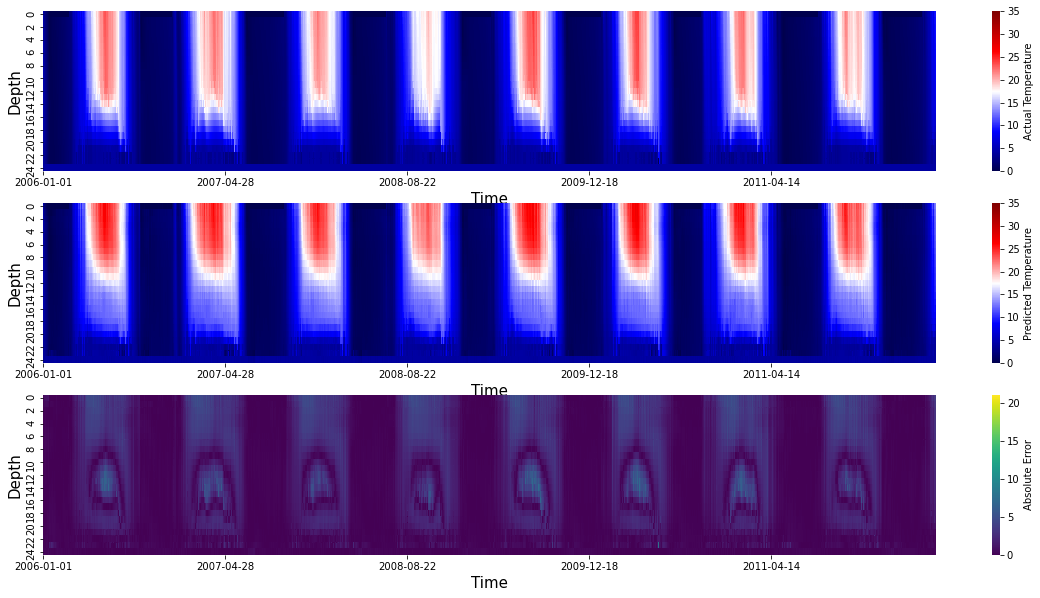

In [41]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

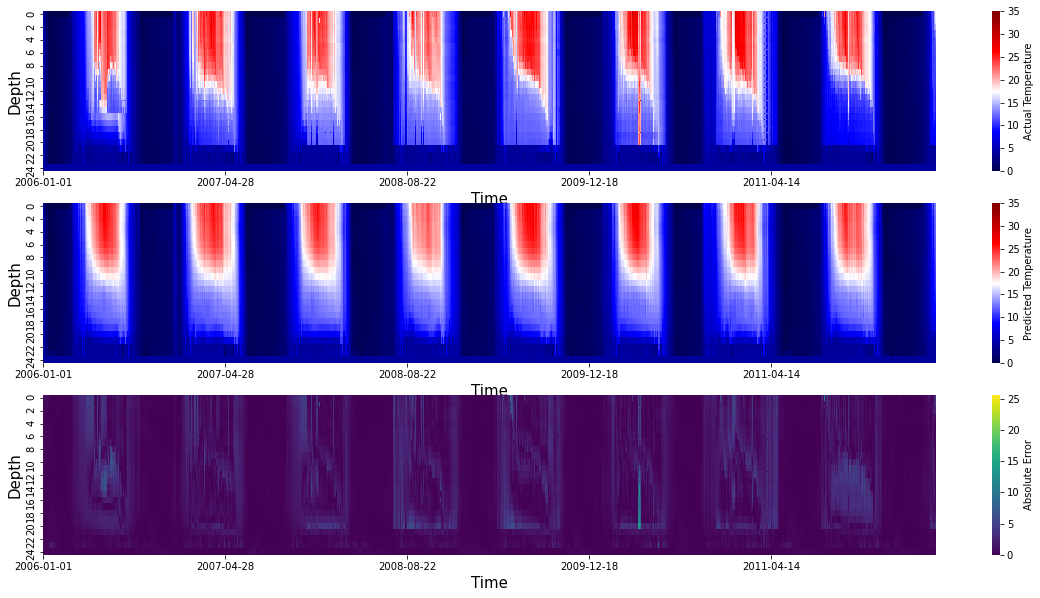

In [42]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [43]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 2.368594
RMSE of after m1 2.4690065
RMSE of after m2 2.4745276
RMSE of after m3 2.3785293
RMSE of after m4 2.3789194
RMSE of after m0 2.691142
RMSE of after m1 2.778105
RMSE of after m2 2.782267
RMSE of after m3 2.6994398
RMSE of after m4 2.6999314
RMSE of after m0 2.4136152
RMSE of after m1 2.5055842
RMSE of after m2 2.5079584
RMSE of after m3 2.4211526
RMSE of after m4 2.4216537
RMSE of after m0 2.4804044
RMSE of after m1 2.569322
RMSE of after m2 2.5733647
RMSE of after m3 2.4891734
RMSE of after m4 2.4897523
RMSE of after m0 2.4683871
RMSE of after m1 2.5636668
RMSE of after m2 2.5616376
RMSE of after m3 2.4711642
RMSE of after m4 2.4718654
RMSE of after m0 2.512332
RMSE of after m1 2.5941603
RMSE of after m2 2.592698
RMSE of after m3 2.5171561
RMSE of after m4 2.5182543
RMSE of after m0 2.4766505
RMSE of after m1 2.5655928
RMSE of after m2 2.5713034
RMSE of after m3 2.4886882
RMSE of after m4 2.4896781
RMSE of after m0 2.6054971
RMSE of after m1 2.6791036
RMSE of 

RMSE of after m0 2.2940059
RMSE of after m1 2.3217185
RMSE of after m2 2.3249123
RMSE of after m3 2.3027623
RMSE of after m4 2.3033628
RMSE of after m0 2.124456
RMSE of after m1 2.1643398
RMSE of after m2 2.1618578
RMSE of after m3 2.1401393
RMSE of after m4 2.140717
RMSE of after m0 2.1961277
RMSE of after m1 2.237908
RMSE of after m2 2.2365048
RMSE of after m3 2.2220633
RMSE of after m4 2.222654
RMSE of after m0 2.2270405
RMSE of after m1 2.2978377
RMSE of after m2 2.2975416
RMSE of after m3 2.2579494
RMSE of after m4 2.2585945
RMSE of after m0 2.2845495
RMSE of after m1 2.3730612
RMSE of after m2 2.375138
RMSE of after m3 2.3122256
RMSE of after m4 2.312901
RMSE of after m0 2.2510781
RMSE of after m1 2.3561995
RMSE of after m2 2.359394
RMSE of after m3 2.2767107
RMSE of after m4 2.277434
RMSE of after m0 2.1758008
RMSE of after m1 2.3019652
RMSE of after m2 2.3046963
RMSE of after m3 2.195278
RMSE of after m4 2.1959655
RMSE of after m0 2.2840593
RMSE of after m1 2.4006054
RMSE of af

RMSE of after m2 0.27982453
RMSE of after m3 0.21215694
RMSE of after m4 0.18069476
RMSE of after m0 0.16155726
RMSE of after m1 0.24834548
RMSE of after m2 0.25129303
RMSE of after m3 0.17419714
RMSE of after m4 0.15558317
RMSE of after m0 0.16246487
RMSE of after m1 0.2507672
RMSE of after m2 0.25417852
RMSE of after m3 0.17042448
RMSE of after m4 0.15262978
RMSE of after m0 0.1584592
RMSE of after m1 0.24820681
RMSE of after m2 0.2534476
RMSE of after m3 0.16367786
RMSE of after m4 0.14757617
RMSE of after m0 0.14511119
RMSE of after m1 0.24749433
RMSE of after m2 0.25332358
RMSE of after m3 0.15396987
RMSE of after m4 0.1481603
RMSE of after m0 0.14308122
RMSE of after m1 0.247333
RMSE of after m2 0.24880357
RMSE of after m3 0.14535533
RMSE of after m4 0.1434413
RMSE of after m0 0.14111665
RMSE of after m1 0.24851607
RMSE of after m2 0.2548022
RMSE of after m3 0.14632013
RMSE of after m4 0.14645891
RMSE of after m0 0.13902687
RMSE of after m1 0.24821961
RMSE of after m2 0.2553793
R

RMSE of after m0 0.8082271
RMSE of after m1 1.0140429
RMSE of after m2 0.87879765
RMSE of after m3 0.8200004
RMSE of after m4 0.82036895
RMSE of after m0 0.68606526
RMSE of after m1 0.98490304
RMSE of after m2 0.746073
RMSE of after m3 0.6964728
RMSE of after m4 0.69690144
RMSE of after m0 0.47315276
RMSE of after m1 0.8833189
RMSE of after m2 0.5813185
RMSE of after m3 0.48046237
RMSE of after m4 0.48083493
RMSE of after m0 0.43382886
RMSE of after m1 0.8229388
RMSE of after m2 0.68307424
RMSE of after m3 0.44793957
RMSE of after m4 0.44821316
RMSE of after m0 0.45623738
RMSE of after m1 0.8156831
RMSE of after m2 0.592103
RMSE of after m3 0.46942124
RMSE of after m4 0.46968523
RMSE of after m0 0.49833938
RMSE of after m1 0.8152702
RMSE of after m2 0.7721218
RMSE of after m3 0.5121212
RMSE of after m4 0.5123925
RMSE of after m0 0.69435537
RMSE of after m1 0.93969756
RMSE of after m2 0.9358019
RMSE of after m3 0.70588017
RMSE of after m4 0.70620775
RMSE of after m0 0.655338
RMSE of aft

RMSE of after m0 3.4065113
RMSE of after m1 3.4250486
RMSE of after m2 3.4232776
RMSE of after m3 3.4147956
RMSE of after m4 3.4149761
RMSE of after m0 3.3797503
RMSE of after m1 3.3987696
RMSE of after m2 3.4008102
RMSE of after m3 3.3918903
RMSE of after m4 3.392081
RMSE of after m0 3.3323443
RMSE of after m1 3.3663266
RMSE of after m2 3.3653984
RMSE of after m3 3.344801
RMSE of after m4 3.344971
RMSE of after m0 3.1360967
RMSE of after m1 3.1870656
RMSE of after m2 3.1899166
RMSE of after m3 3.1523905
RMSE of after m4 3.1525614
RMSE of after m0 2.98773
RMSE of after m1 3.0457532
RMSE of after m2 3.047671
RMSE of after m3 3.0040495
RMSE of after m4 3.0042298
RMSE of after m0 3.2214007
RMSE of after m1 3.2788236
RMSE of after m2 3.283972
RMSE of after m3 3.2347376
RMSE of after m4 3.2349052
RMSE of after m0 3.232477
RMSE of after m1 3.2940762
RMSE of after m2 3.2979033
RMSE of after m3 3.246215
RMSE of after m4 3.2463536
RMSE of after m0 3.277141
RMSE of after m1 3.339301
RMSE of afte

RMSE of after m0 0.52601826
RMSE of after m1 0.7376954
RMSE of after m2 0.7139099
RMSE of after m3 0.5370588
RMSE of after m4 0.53721917
RMSE of after m0 0.5530211
RMSE of after m1 0.7160075
RMSE of after m2 0.6812954
RMSE of after m3 0.55850595
RMSE of after m4 0.558618
RMSE of after m0 0.52254385
RMSE of after m1 0.6580467
RMSE of after m2 0.650249
RMSE of after m3 0.52449775
RMSE of after m4 0.52462083
RMSE of after m0 0.5787509
RMSE of after m1 0.6797938
RMSE of after m2 0.6163699
RMSE of after m3 0.57556325
RMSE of after m4 0.5756952
RMSE of after m0 0.65890956
RMSE of after m1 0.7319989
RMSE of after m2 0.6953044
RMSE of after m3 0.65970117
RMSE of after m4 0.6598431
RMSE of after m0 0.66500676
RMSE of after m1 0.73582894
RMSE of after m2 0.71639794
RMSE of after m3 0.65930223
RMSE of after m4 0.6594715
RMSE of after m0 0.9660012
RMSE of after m1 1.0194131
RMSE of after m2 0.99929374
RMSE of after m3 0.9550696
RMSE of after m4 0.9554892
RMSE of after m0 0.73878443
RMSE of after m

RMSE of after m0 0.24700959
RMSE of after m1 0.3160349
RMSE of after m2 0.27410093
RMSE of after m3 0.24390969
RMSE of after m4 0.24410169
RMSE of after m0 0.18208472
RMSE of after m1 0.35747468
RMSE of after m2 0.28643724
RMSE of after m3 0.18457808
RMSE of after m4 0.18494369
RMSE of after m0 0.16722226
RMSE of after m1 0.36703286
RMSE of after m2 0.37037328
RMSE of after m3 0.16821131
RMSE of after m4 0.1685519
RMSE of after m0 0.15850486
RMSE of after m1 0.35961634
RMSE of after m2 0.30404007
RMSE of after m3 0.16155672
RMSE of after m4 0.16174284
RMSE of after m0 0.19723426
RMSE of after m1 0.3415297
RMSE of after m2 0.28076828
RMSE of after m3 0.19855079
RMSE of after m4 0.19882026
RMSE of after m0 0.17274381
RMSE of after m1 0.36238188
RMSE of after m2 0.19254169
RMSE of after m3 0.17467436
RMSE of after m4 0.17489222
RMSE of after m0 0.1712397
RMSE of after m1 0.3457417
RMSE of after m2 0.34804237
RMSE of after m3 0.16708778
RMSE of after m4 0.16623123
RMSE of after m0 0.218256

RMSE of after m0 2.5595186
RMSE of after m1 2.680965
RMSE of after m2 2.6807241
RMSE of after m3 2.5551758
RMSE of after m4 2.5556045
RMSE of after m0 2.5298796
RMSE of after m1 2.6582465
RMSE of after m2 2.6620467
RMSE of after m3 2.5272217
RMSE of after m4 2.527535
RMSE of after m0 2.6287897
RMSE of after m1 2.7561917
RMSE of after m2 2.757732
RMSE of after m3 2.623534
RMSE of after m4 2.623761
RMSE of after m0 2.6289475
RMSE of after m1 2.760048
RMSE of after m2 2.7643166
RMSE of after m3 2.6240764
RMSE of after m4 2.6241953
RMSE of after m0 2.5836964
RMSE of after m1 2.7105796
RMSE of after m2 2.7156427
RMSE of after m3 2.5814922
RMSE of after m4 2.5815516
RMSE of after m0 2.6810446
RMSE of after m1 2.8036673
RMSE of after m2 2.8076494
RMSE of after m3 2.676382
RMSE of after m4 2.6763775
RMSE of after m0 3.0347977
RMSE of after m1 3.1475987
RMSE of after m2 3.1454608
RMSE of after m3 3.0182827
RMSE of after m4 3.0180867
RMSE of after m0 3.025289
RMSE of after m1 3.1413176
RMSE of a

RMSE of after m0 2.0854664
RMSE of after m1 2.1686606
RMSE of after m2 2.1690047
RMSE of after m3 2.0835574
RMSE of after m4 2.084335
RMSE of after m0 1.9837189
RMSE of after m1 2.0515358
RMSE of after m2 2.0528843
RMSE of after m3 1.9928443
RMSE of after m4 1.9933372
RMSE of after m0 1.9156262
RMSE of after m1 1.9705428
RMSE of after m2 1.974507
RMSE of after m3 1.9324379
RMSE of after m4 1.9325542
RMSE of after m0 2.0637934
RMSE of after m1 2.1190348
RMSE of after m2 2.1261158
RMSE of after m3 2.088475
RMSE of after m4 2.0884573
RMSE of after m0 2.0158496
RMSE of after m1 2.0767238
RMSE of after m2 2.0888994
RMSE of after m3 2.0459392
RMSE of after m4 2.0457208
RMSE of after m0 2.1367
RMSE of after m1 2.207915
RMSE of after m2 2.229669
RMSE of after m3 2.1709535
RMSE of after m4 2.1706312
RMSE of after m0 2.2899752
RMSE of after m1 2.3785565
RMSE of after m2 2.555884
RMSE of after m3 4.1907887
RMSE of after m4 2.5528474
RMSE of after m0 2.307476
RMSE of after m1 2.4525342
RMSE of aft

RMSE of after m0 0.19747102
RMSE of after m1 0.30435324
RMSE of after m2 0.30503458
RMSE of after m3 0.18904434
RMSE of after m4 0.15161684
RMSE of after m0 0.18110237
RMSE of after m1 0.32177076
RMSE of after m2 0.32554406
RMSE of after m3 0.16853176
RMSE of after m4 0.13618174
RMSE of after m0 0.14417502
RMSE of after m1 0.3363107
RMSE of after m2 0.33875716
RMSE of after m3 0.14741465
RMSE of after m4 0.14319795
RMSE of after m0 0.1389502
RMSE of after m1 0.3256186
RMSE of after m2 0.32485086
RMSE of after m3 0.1316336
RMSE of after m4 0.11847805
RMSE of after m0 0.20777066
RMSE of after m1 0.33545747
RMSE of after m2 0.3331394
RMSE of after m3 0.19226378
RMSE of after m4 0.1588753
RMSE of after m0 0.1640096
RMSE of after m1 0.35114044
RMSE of after m2 0.35382593
RMSE of after m3 0.15765204
RMSE of after m4 0.1388536
RMSE of after m0 0.160432
RMSE of after m1 0.35684755
RMSE of after m2 0.3571034
RMSE of after m3 0.1537459
RMSE of after m4 0.13981171
RMSE of after m0 0.25161406
RMSE

RMSE of after m4 2.497086
RMSE of after m0 2.5744896
RMSE of after m1 2.6405091
RMSE of after m2 2.6423829
RMSE of after m3 2.5832286
RMSE of after m4 2.5842729
RMSE of after m0 2.450741
RMSE of after m1 2.5695353
RMSE of after m2 2.589969
RMSE of after m3 2.4768357
RMSE of after m4 2.4780881
RMSE of after m0 2.4639072
RMSE of after m1 2.5355985
RMSE of after m2 2.5349317
RMSE of after m3 2.4790058
RMSE of after m4 2.4808424
RMSE of after m0 2.4787867
RMSE of after m1 2.5871189
RMSE of after m2 2.5813913
RMSE of after m3 2.485005
RMSE of after m4 2.4870272
RMSE of after m0 2.543082
RMSE of after m1 2.6607046
RMSE of after m2 2.6522706
RMSE of after m3 2.5385983
RMSE of after m4 2.5408332
RMSE of after m0 2.6487327
RMSE of after m1 2.7813668
RMSE of after m2 2.7796109
RMSE of after m3 2.6443834
RMSE of after m4 2.6469142
RMSE of after m0 2.552602
RMSE of after m1 2.680531
RMSE of after m2 2.6754415
RMSE of after m3 2.5434694
RMSE of after m4 2.5456066
RMSE of after m0 2.5368679
RMSE of 

RMSE of after m2 2.4360764
RMSE of after m3 2.3212461
RMSE of after m4 2.3221383
RMSE of after m0 2.0324836
RMSE of after m1 2.1355853
RMSE of after m2 2.1365108
RMSE of after m3 2.0529697
RMSE of after m4 2.0538733
RMSE of after m0 2.1252158
RMSE of after m1 2.2311661
RMSE of after m2 2.2389038
RMSE of after m3 2.1484845
RMSE of after m4 2.1494129
RMSE of after m0 2.0807157
RMSE of after m1 2.1279254
RMSE of after m2 2.1250741
RMSE of after m3 2.093741
RMSE of after m4 2.0946648
RMSE of after m0 2.0572832
RMSE of after m1 2.1204257
RMSE of after m2 2.1158133
RMSE of after m3 2.0782647
RMSE of after m4 2.0791333
RMSE of after m0 2.0664415
RMSE of after m1 2.1473322
RMSE of after m2 2.1454475
RMSE of after m3 2.085624
RMSE of after m4 2.08638
RMSE of after m0 2.0426252
RMSE of after m1 2.1437805
RMSE of after m2 2.1403704
RMSE of after m3 2.0594902
RMSE of after m4 2.060223
RMSE of after m0 2.0341053
RMSE of after m1 2.1268122
RMSE of after m2 2.128494
RMSE of after m3 2.052335
RMSE of 

RMSE of after m1 0.25127846
RMSE of after m2 0.2619185
RMSE of after m3 0.14116086
RMSE of after m4 0.13891856
RMSE of after m0 0.13841347
RMSE of after m1 0.25798243
RMSE of after m2 0.26460382
RMSE of after m3 0.14203723
RMSE of after m4 0.1381967
RMSE of after m0 0.13282633
RMSE of after m1 0.2551458
RMSE of after m2 0.26566526
RMSE of after m3 0.1380805
RMSE of after m4 0.13594215
RMSE of after m0 0.13474144
RMSE of after m1 0.25671133
RMSE of after m2 0.26376194
RMSE of after m3 0.1360922
RMSE of after m4 0.13093165
RMSE of after m0 0.13289976
RMSE of after m1 0.26026037
RMSE of after m2 0.2698511
RMSE of after m3 0.13605674
RMSE of after m4 0.13406962
RMSE of after m0 0.1404462
RMSE of after m1 0.26846454
RMSE of after m2 0.27480847
RMSE of after m3 0.13920744
RMSE of after m4 0.13225873
RMSE of after m0 0.14762156
RMSE of after m1 0.27649096
RMSE of after m2 0.28432402
RMSE of after m3 0.15250397
RMSE of after m4 0.14265743
RMSE of after m0 0.17369919
RMSE of after m1 0.2900729


RMSE of after m1 1.468175
RMSE of after m2 1.3101376
RMSE of after m3 1.2344619
RMSE of after m4 1.2348924
RMSE of after m0 1.3977139
RMSE of after m1 1.5886312
RMSE of after m2 1.5923631
RMSE of after m3 1.4225392
RMSE of after m4 1.4229251
RMSE of after m0 1.9295986
RMSE of after m1 2.0471413
RMSE of after m2 2.0529914
RMSE of after m3 1.9380585
RMSE of after m4 1.9385934
RMSE of after m0 1.8890487
RMSE of after m1 2.0051768
RMSE of after m2 2.0095618
RMSE of after m3 1.8957738
RMSE of after m4 1.8964128
RMSE of after m0 1.8857149
RMSE of after m1 2.0185525
RMSE of after m2 2.0129223
RMSE of after m3 1.8884283
RMSE of after m4 1.8889973
RMSE of after m0 2.13245
RMSE of after m1 2.246279
RMSE of after m2 2.2512014
RMSE of after m3 2.1428297
RMSE of after m4 2.1433518
RMSE of after m0 1.9182959
RMSE of after m1 2.0372953
RMSE of after m2 2.0431397
RMSE of after m3 1.9321063
RMSE of after m4 1.9325485
RMSE of after m0 2.3052406
RMSE of after m1 2.409076
RMSE of after m2 2.4142122
RMSE o

RMSE of after m0 3.2191179
RMSE of after m1 3.3236463
RMSE of after m2 3.3363264
RMSE of after m3 3.2241375
RMSE of after m4 3.2240934
RMSE of after m0 2.921462
RMSE of after m1 3.0342288
RMSE of after m2 3.0408273
RMSE of after m3 2.9240947
RMSE of after m4 2.9240541
RMSE of after m0 2.7761621
RMSE of after m1 2.8809893
RMSE of after m2 2.8854709
RMSE of after m3 2.7798471
RMSE of after m4 2.7798405
RMSE of after m0 3.0852058
RMSE of after m1 3.186078
RMSE of after m2 3.1931384
RMSE of after m3 3.092513
RMSE of after m4 3.0924363
RMSE of after m0 3.0371141
RMSE of after m1 3.1478698
RMSE of after m2 3.1552546
RMSE of after m3 3.0458012
RMSE of after m4 3.0456877
RMSE of after m0 2.954184
RMSE of after m1 3.0647964
RMSE of after m2 3.0719364
RMSE of after m3 2.9644985
RMSE of after m4 2.964367
RMSE of after m0 2.550738
RMSE of after m1 2.6692233
RMSE of after m2 2.672307
RMSE of after m3 2.5601053
RMSE of after m4 2.5600605
RMSE of after m0 2.408907
RMSE of after m1 2.5312362
RMSE of a

RMSE of after m2 0.23615934
RMSE of after m3 0.25572816
RMSE of after m4 0.2555895
RMSE of after m0 0.16576476
RMSE of after m1 0.19549544
RMSE of after m2 0.19727685
RMSE of after m3 0.17636465
RMSE of after m4 0.1762348
RMSE of after m0 0.19118156
RMSE of after m1 0.22438407
RMSE of after m2 0.22264306
RMSE of after m3 0.20005158
RMSE of after m4 0.1996269
RMSE of after m0 0.17139432
RMSE of after m1 0.19789444
RMSE of after m2 0.2009525
RMSE of after m3 0.18401302
RMSE of after m4 0.18382822
RMSE of after m0 0.23960675
RMSE of after m1 0.25015447
RMSE of after m2 0.24387029
RMSE of after m3 0.23898463
RMSE of after m4 0.23927432
RMSE of after m0 0.19670142
RMSE of after m1 0.23234291
RMSE of after m2 0.22622426
RMSE of after m3 0.20802335
RMSE of after m4 0.207141
RMSE of after m0 0.17688403
RMSE of after m1 0.2197841
RMSE of after m2 0.21572627
RMSE of after m3 0.19462195
RMSE of after m4 0.19317086
RMSE of after m0 0.19576226
RMSE of after m1 0.26967764
RMSE of after m2 0.27361518

RMSE of after m0 0.18449116
RMSE of after m1 0.49744713
RMSE of after m2 0.3929748
RMSE of after m3 0.20734124
RMSE of after m4 0.20758133
RMSE of after m0 0.40257385
RMSE of after m1 0.5676244
RMSE of after m2 0.51633847
RMSE of after m3 0.40854347
RMSE of after m4 0.40871534
RMSE of after m0 0.4856714
RMSE of after m1 0.6476829
RMSE of after m2 0.4931934
RMSE of after m3 0.4866503
RMSE of after m4 0.48677692
RMSE of after m0 0.36896232
RMSE of after m1 0.6361313
RMSE of after m2 0.5195105
RMSE of after m3 0.37686533
RMSE of after m4 0.37704036
RMSE of after m0 0.64254487
RMSE of after m1 0.83360314
RMSE of after m2 0.762262
RMSE of after m3 0.6494181
RMSE of after m4 0.6496556
RMSE of after m0 0.8389893
RMSE of after m1 1.0204055
RMSE of after m2 0.8892784
RMSE of after m3 0.84723705
RMSE of after m4 0.84757084
RMSE of after m0 0.7867198
RMSE of after m1 1.0216852
RMSE of after m2 0.980469
RMSE of after m3 0.79667723
RMSE of after m4 0.7970674
RMSE of after m0 0.8226115
RMSE of after

RMSE of after m0 2.549842
RMSE of after m1 2.6920042
RMSE of after m2 2.699762
RMSE of after m3 2.5466666
RMSE of after m4 2.5467439
RMSE of after m0 2.5372546
RMSE of after m1 2.6761112
RMSE of after m2 2.682752
RMSE of after m3 2.5333645
RMSE of after m4 2.533431
RMSE of after m0 2.4631746
RMSE of after m1 2.6109235
RMSE of after m2 2.6199365
RMSE of after m3 2.4608543
RMSE of after m4 2.4609034
RMSE of after m0 2.2622786
RMSE of after m1 2.4166195
RMSE of after m2 2.4232774
RMSE of after m3 2.2602417
RMSE of after m4 2.2603538
RMSE of after m0 2.195623
RMSE of after m1 2.3519862
RMSE of after m2 2.3572977
RMSE of after m3 2.193545
RMSE of after m4 2.193693
RMSE of after m0 2.4293902
RMSE of after m1 2.5728407
RMSE of after m2 2.57949
RMSE of after m3 2.4283895
RMSE of after m4 2.428521
RMSE of after m0 2.3765364
RMSE of after m1 2.5177615
RMSE of after m2 2.5282006
RMSE of after m3 2.3802092
RMSE of after m4 2.380327
RMSE of after m0 2.6718092
RMSE of after m1 2.788386
RMSE of after

RMSE of after m0 0.43161663
RMSE of after m1 0.4388098
RMSE of after m2 0.6307266
RMSE of after m3 0.6776435
RMSE of after m4 0.6779111
RMSE of after m0 0.3474981
RMSE of after m1 0.35456505
RMSE of after m2 0.35537434
RMSE of after m3 0.59038776
RMSE of after m4 0.5905171
RMSE of after m0 0.3737807
RMSE of after m1 0.3741883
RMSE of after m2 0.5458196
RMSE of after m3 0.59954
RMSE of after m4 0.59967697
RMSE of after m0 0.28215033
RMSE of after m1 0.28795275
RMSE of after m2 0.46765777
RMSE of after m3 0.5401984
RMSE of after m4 0.5401613
RMSE of after m0 0.29207894
RMSE of after m1 0.29083413
RMSE of after m2 0.42932197
RMSE of after m3 0.4924124
RMSE of after m4 0.4923206
RMSE of after m0 0.24136838
RMSE of after m1 0.24020241
RMSE of after m2 0.23739557
RMSE of after m3 0.34299162
RMSE of after m4 0.34176305
RMSE of after m0 0.23137149
RMSE of after m1 0.23370665
RMSE of after m2 0.22689623
RMSE of after m3 0.36804664
RMSE of after m4 0.36656612
RMSE of after m0 0.27115968
RMSE of 

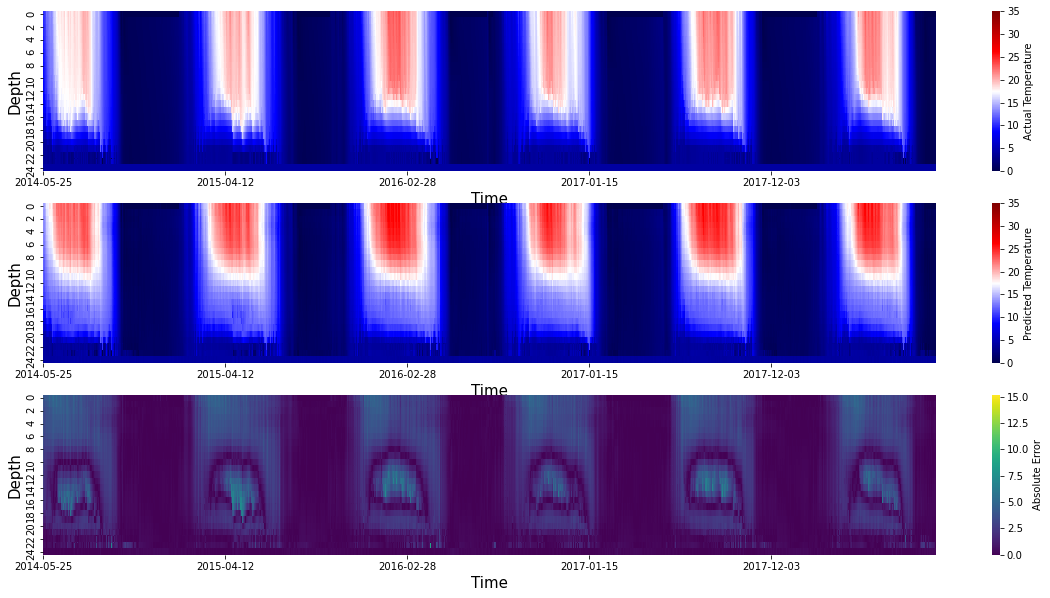

In [44]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

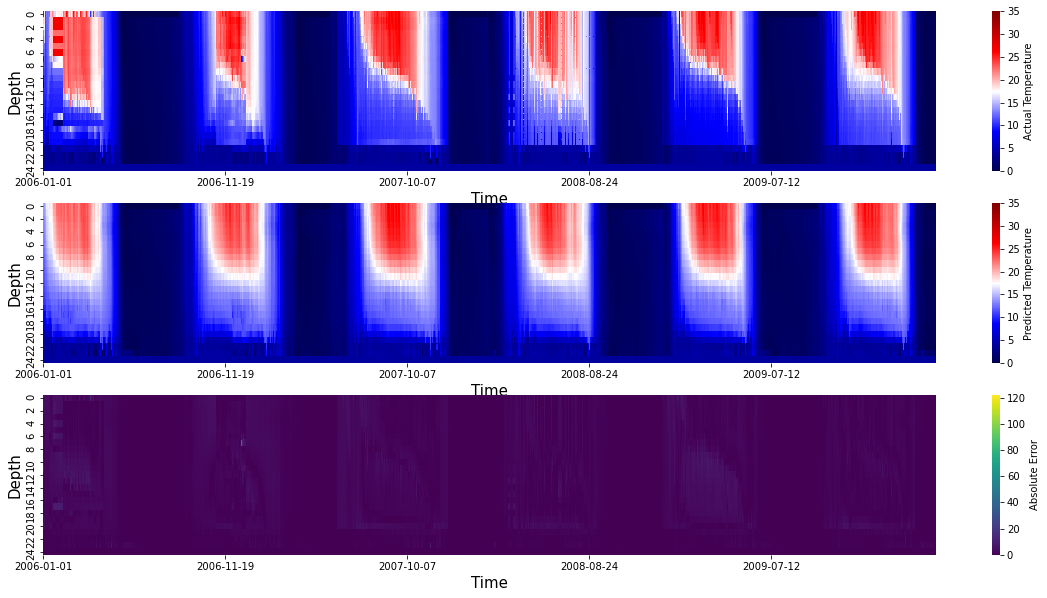

In [45]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [46]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 11.395342155022304, Train L2 Error: 1.1868947968576393
Test RMSE: 12.028427025260507, Train L2 Error: 1.1740138800862012


## Mixing Model

In [47]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.11018267930181727, Train L2 Error: 0.011469719278175432
Test RMSE: 0.121947361205087, Train L2 Error: 0.011897466396861693


## Convection Model

In [48]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.10238946186873105, Train L2 Error: 0.010641804283639112
Test RMSE: 0.11916663876987295, Train L2 Error: 0.011609599613482435


## Ice Model

In [49]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0011646093493033137, Train L2 Error: 0.00012104342580499258
Test RMSE: 0.0022081818962783406, Train L2 Error: 0.00021512855883762218


# Compute Model Similarity after Finetuning

In [50]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [51]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9595388174057007
L2 Norm: 3.6486706733703613


In [52]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [53]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [54]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [55]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [56]:
# Freeze all models again and compute finetuned diffusivity values

In [57]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [58]:
PATH = f"./saved_models/heating_model_finetuned.pth"
torch.save(heating_model.state_dict(), PATH)